In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Import PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

pd.set_option('display.max_columns', None)

In [2]:
# Get all csv files starting with 'g_15' in data directory
data_dir = '../data'
csv_files = [f for f in os.listdir(data_dir) if f.startswith('g_15-2') and f.endswith('.csv')]

# Read and combine all matching CSV files
dfs = []
for file in csv_files:
    df = pd.read_csv(os.path.join(data_dir, file))
    df['game_date'] = pd.to_datetime(df['game_date'])  # Convert date for sorting
    dfs.append(df)

# Concatenate all dataframes and sort by game_date
processed_df = pd.concat(dfs, ignore_index=True)
processed_df = processed_df.sort_values('game_date').reset_index(drop=True)

In [3]:
# list(processed_df.columns)
processed_df

,game_date,game_id,home,team,gp,toi,point_pct,cf,ca,cf_pct,ff,fa,ff_pct,sf,sa,sf_pct,gf,ga,gf_pct,xgf,xga,xgf_pct,scf,sca,scf_pct,scsf,scsa,scsf_pct,scgf,scga,scgf_pct,scsh_pct,scsv_pct,hdcf,hdca,hdcf_pct,hdsf,hdsa,hdsf_pct,hdgf,hdga,hdgf_pct,hdsh_pct,hdsv_pct,mdcf,mdca,mdcf_pct,mdsf,mdsa,mdsf_pct,mdgf,mdga,mdgf_pct,mdsh_pct,mdsv_pct,ldcf,ldca,ldcf_pct,ldsf,ldsa,ldsf_pct,ldgf,ldga,ldgf_pct,ldsh_pct,ldsv_pct,sh_pct,sv_pct,pdo,pp_toi,pp_point_pct,pp_cf,pp_ca,pp_cf_pct,pp_ff,pp_fa,pp_ff_pct,pp_sf,pp_sa,pp_sf_pct,pp_gf,pp_ga,pp_gf_pct,pp_xgf,pp_xga,pp_xgf_pct,pp_scf,pp_sca,pp_scf_pct,pp_scsf,pp_scsa,pp_scsf_pct,pp_scgf,pp_scga,pp_scgf_pct,pp_scsh_pct,pp_scsv_pct,pp_hdcf,pp_hdca,pp_hdcf_pct,pp_hdsf,pp_hdsa,pp_hdsf_pct,pp_hdgf,pp_hdga,pp_hdgf_pct,pp_hdsh_pct,pp_hdsv_pct,pp_mdcf,pp_mdca,pp_mdcf_pct,pp_mdsf,pp_mdsa,pp_mdsf_pct,pp_mdgf,pp_mdga,pp_mdgf_pct,pp_mdsh_pct,pp_mdsv_pct,pp_ldcf,pp_ldca,pp_ldcf_pct,pp_ldsf,pp_ldsa,pp_ldsf_pct,pp_ldgf,pp_ldga,pp_ldgf_pct,pp_ldsh_pct,pp_ldsv_pct,pp_sh_pct,pp_sv_pct,pp_pdo,pk_toi,pk_point_pct,pk_cf,pk_ca,pk_cf_pct,pk_ff,pk_fa,pk_ff_pct,pk_sf,pk_sa,pk_sf_pct,pk_gf,pk_ga,pk_gf_pct,pk_xgf,pk_xga,pk_xgf_pct,pk_scf,pk_sca,pk_scf_pct,pk_scsf,pk_scsa,pk_scsf_pct,pk_scgf,pk_scga,pk_scgf_pct,pk_scsh_pct,pk_scsv_pct,pk_hdcf,pk_hdca,pk_hdcf_pct,pk_hdsf,pk_hdsa,pk_hdsf_pct,pk_hdgf,pk_hdga,pk_hdgf_pct,pk_hdsh_pct,pk_hdsv_pct,pk_mdcf,pk_mdca,pk_mdcf_pct,pk_mdsf,pk_mdsa,pk_mdsf_pct,pk_mdgf,pk_mdga,pk_mdgf_pct,pk_mdsh_pct,pk_mdsv_pct,pk_ldcf,pk_ldca,pk_ldcf_pct,pk_ldsf,pk_ldsa,pk_ldsf_pct,pk_ldgf,pk_ldga,pk_ldgf_pct,pk_ldsh_pct,pk_ldsv_pct,pk_sh_pct,pk_sv_pct,pk_pdo,b2b,opp_b2b,last_game_date,season,goalie_name,goalie_team,goalie_id,g_sa_roll_avg,g_sa_roll_std,g_sv_pct_roll_avg,g_sv_pct_roll_std,g_gaa_roll_avg,g_gaa_roll_std,g_gsaa_roll_avg,g_gsaa_roll_std,g_xg_against_roll_avg,g_xg_against_roll_std,g_hd_sa_roll_avg,g_hd_sa_roll_std,g_hdsv_pct_roll_avg,g_hdsv_pct_roll_std,g_md_sa_roll_avg,g_md_sa_roll_std,g_mdsv_pct_roll_avg,g_mdsv_pct_roll_std,g_ld_sa_roll_avg,g_ld_sa_roll_std,g_ldsv_pct_roll_avg,g_ldsv_pct_roll_std,g_rest,g_l7,res_sv,res_sa,res_sv_pct,res_ga,res_des,res_toi
0,2021-10-12,2021020001,False,PIT,1,53.900,0.000,47,54,46.535,33,44,42.857,23,32,41.818,0,3,0.000,1.32,2.53,34.286,17,34,33.333,8,23,25.806,0,2,0.000,0.000,91.304,4,12,25.000,3,10,23.077,0,2,0.000,0.000,80.000,13,22,37.143,5,13,27.778,0,0,NaN,0.000,100.000,35,31,53.030,12,9,57.143,0,1,0.000,0.000,88.889,0.000,90.625,0.906,2.000,0.000,2.0,0.0,100.000,2.0,0.0,100.000,1.0,0.0,100.000,0.0,0.0,NaN,0.22,0.00,100.000,2.0,0.0,100.000,1.0,0.0,100.000,0.0,0.0,NaN,0.000,NaN,1.0,0.0,100.000,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,0.0,100.000,1.0,0.0,100.000,0.0,0.0,NaN,0.000,NaN,2.0,0.0,100.000,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.000,NaN,NaN,2.000,0.000,1.0,1.0,50.000,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.00,0.00,NaN,1.0,1.0,50.000,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,1.0,1.0,50.000,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2021-10-12,20212022,Tristan Jarry,PIT,8477465,23.3,8.028422,0.8829,0.146958,2.865,2.798350,0.162,1.271096,1.790,0.729399,5.0,2.449490,0.787100,0.295684,5.7,2.830391,0.8181,0.316545,11.7,5.396501,0.9738,0.042762,2.0,4.0,26.0,28.0,0.929,2.0,W,60:00
1,2021-10-12,2021020002,True,VGK,1,45.720,0.000,51,43,54.255,39,33,54.167,26,21,55.319,3,4,42.857,2.15,2.23,49.087,22,21,51.163,12,10,54.545,2,4,33.333,16.667,60.000,11,8,57.895,5,7,41.667,2,3,40.000,40.000,57.143,11,13,45.833,7,3,70.000,0,1,0.000,0.000,66.667,26,21,55.319,14,11,56.000,1,0,100.000,7.143,100.000,11.538,80.952,0.925,6.000,0.000,7.0,1.0,87.500,3.0,1.0,75.000,3.0,1.0,75.000,0.0,0.0,NaN,0.27,0.00,100.000,4.0,0.0,100.000,2.0,0.0,100.000,0.0,0.0,NaN,0.000,NaN,1.0,0.0,100.000,1.0,0.0,100.000,0.0,0.0,NaN,0.000,NaN,3.0,0.0,100.000,1.0,0.0,100.000,0.0,0.0,NaN,0.000,NaN,3.0,0.0,100.000,1.0,0.0,100.000,0.0,0.0,NaN,0.000,NaN,0.000,100.000,1.000,6.000,0.000,0.0,11.0,0.000,0.0,11.0,0.000,0.0,7.0,0.000,0.0,0.0

In [4]:
# Filter out rows before 2022-10-07
processed_df = processed_df[processed_df['game_date'] >= '2022-10-07'].reset_index(drop=True)

# Display the date range in the filtered dataset
print(f"Date range in filtered dataset: {processed_df['game_date'].min()} to {processed_df['game_date'].max()}")
print(f"Number of rows after filtering: {len(processed_df)}")

Date range in filtered dataset: 2022-10-07 00:00:00 to 2025-01-31 00:00:00
Number of rows after filtering: 6124


Top 15 features positively correlated with res_sv:
sf_pct      0.328451
ff_pct      0.318257
cf_pct      0.316915
ldcf_pct    0.285636
ldsf_pct    0.283716
xgf_pct     0.275849
scf_pct     0.271955
scsf_pct    0.256600
mdcf_pct    0.241394
hdcf_pct    0.226220
hdsf_pct    0.210917
mdsf_pct    0.208992
sf          0.195460
scsf        0.179756
ldsf        0.176379
Name: res_sv, dtype: float64

Top 15 features negatively correlated with res_sv:
sh_pct      -0.196206
scsh_pct    -0.195433
ldca        -0.145190
mdsh_pct    -0.144676
pdo         -0.143049
hdsh_pct    -0.135832
ca          -0.123893
game_id     -0.122364
season      -0.122356
pp_sh_pct   -0.109319
fa          -0.105957
pk_ldca     -0.104507
mdca        -0.104170
sca         -0.102467
xga         -0.098777
Name: res_sv, dtype: float64


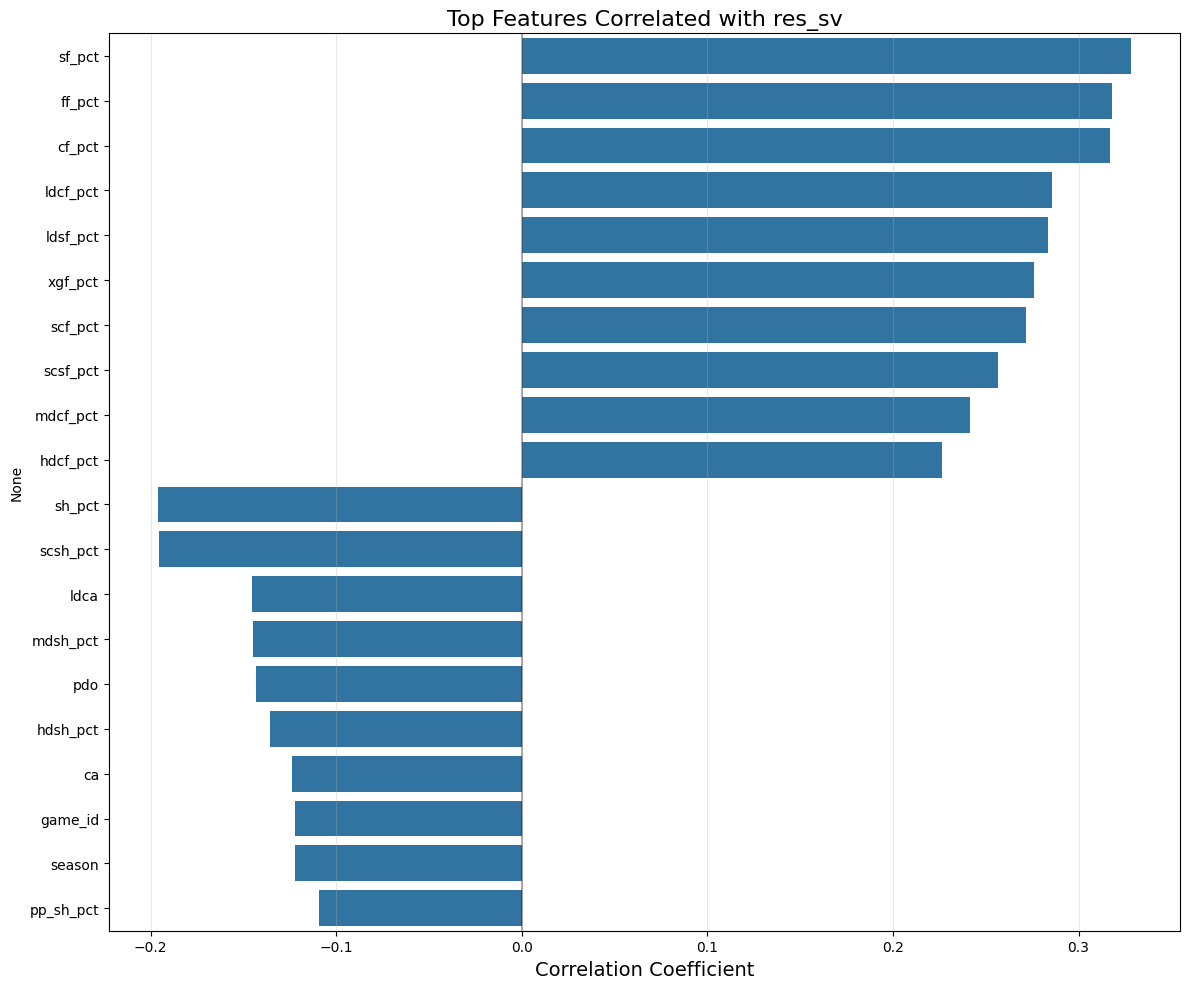

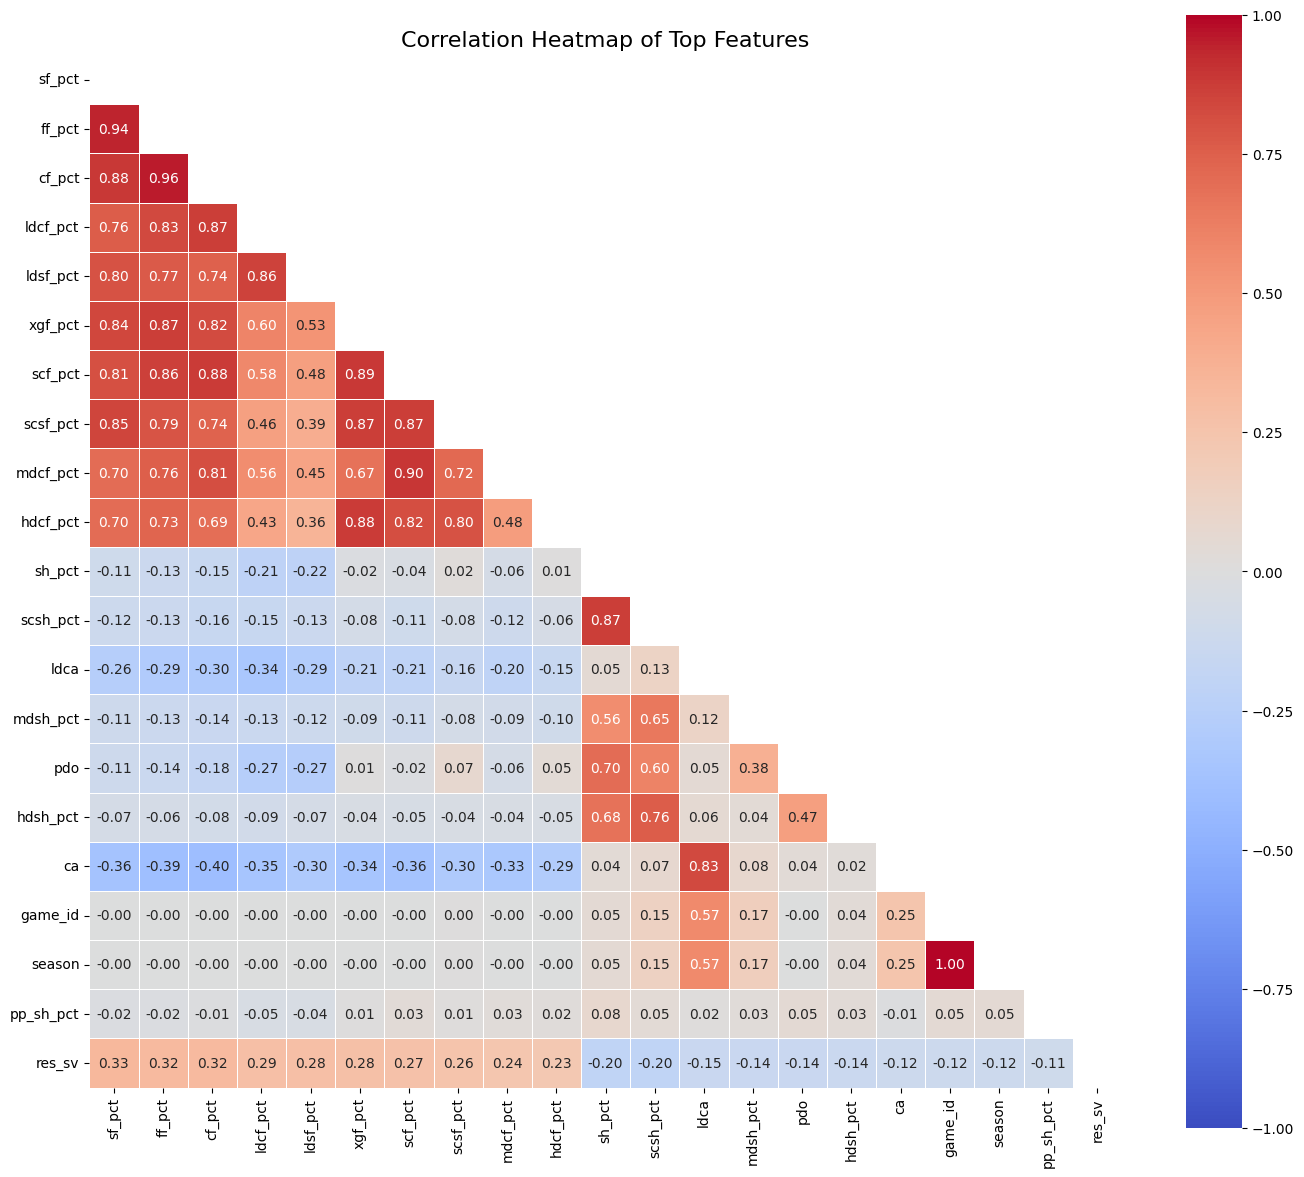


Checking for multicollinearity among top 10 positively correlated features:
          sf_pct  ff_pct  cf_pct  ldcf_pct  ldsf_pct  xgf_pct  scf_pct  \
sf_pct      1.00    0.94    0.88      0.76      0.80     0.84     0.81   
ff_pct      0.94    1.00    0.96      0.83      0.77     0.87     0.86   
cf_pct      0.88    0.96    1.00      0.87      0.74     0.82     0.88   
ldcf_pct    0.76    0.83    0.87      1.00      0.86     0.60     0.58   
ldsf_pct    0.80    0.77    0.74      0.86      1.00     0.53     0.48   
xgf_pct     0.84    0.87    0.82      0.60      0.53     1.00     0.89   
scf_pct     0.81    0.86    0.88      0.58      0.48     0.89     1.00   
scsf_pct    0.85    0.79    0.74      0.46      0.39     0.87     0.87   
mdcf_pct    0.70    0.76    0.81      0.56      0.45     0.67     0.90   
hdcf_pct    0.70    0.73    0.69      0.43      0.36     0.88     0.82   

          scsf_pct  mdcf_pct  hdcf_pct  
sf_pct        0.85      0.70      0.70  
ff_pct        0.79      0.

In [14]:
# First, let's identify numeric columns only
numeric_cols = processed_df.select_dtypes(include=['number']).columns.tolist()

# Make sure 'res_sv' is in the numeric columns
if 'res_sv' not in numeric_cols:
    print("Warning: 'res_sv' is not a numeric column. Please check your data.")
else:
    # Calculate correlations with the target variable (numeric columns only)
    correlations = processed_df[numeric_cols].corr()['res_sv'].sort_values(ascending=False)
    
    # Filter out any columns containing 'res' in their name
    filtered_correlations = correlations[~correlations.index.str.contains('res')]
    
    # Display the top correlations
    print("Top 15 features positively correlated with res_sv:")
    print(filtered_correlations.head(15))
    print("\nTop 15 features negatively correlated with res_sv:")
    print(filtered_correlations.tail(15).iloc[::-1])
    
    # Create a visualization of the top correlations
    plt.figure(figsize=(12, 10))
    
    # Combine top positive and negative correlations
    top_positive = filtered_correlations.head(10)
    top_negative = filtered_correlations.tail(10).iloc[::-1]
    
    # Handle case where we might have fewer than 10 features
    top_features = pd.concat([top_positive, top_negative])
    
    # Create a horizontal bar chart
    sns.barplot(x=top_features.values, y=top_features.index)
    plt.title('Top Features Correlated with res_sv', fontsize=16)
    plt.xlabel('Correlation Coefficient', fontsize=14)
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Create a correlation heatmap for the top correlated features
    top_feature_names = top_features.index.tolist()
    if 'res_sv' not in top_feature_names:
        top_feature_names.append('res_sv')  # Add the target variable
    
    plt.figure(figsize=(14, 12))
    correlation_matrix = processed_df[top_feature_names].corr()
    mask = np.triu(correlation_matrix)
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", 
                mask=mask, vmin=-1, vmax=1, center=0, square=True, linewidths=.5)
    plt.title('Correlation Heatmap of Top Features', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Optional: Check for multicollinearity among top features
    print("\nChecking for multicollinearity among top 10 positively correlated features:")
    top_pos_features = filtered_correlations.head(10).index.tolist()
    print(processed_df[top_pos_features].corr().round(2))

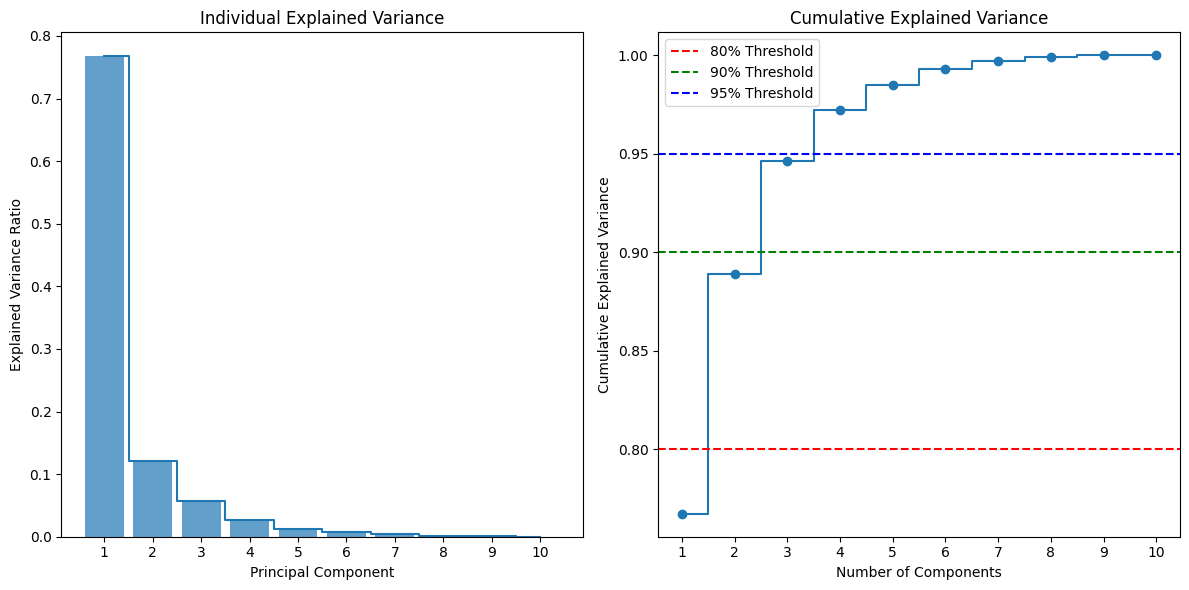

PC1: 0.7674 (0.7674 cumulative)
PC2: 0.1217 (0.8890 cumulative)
PC3: 0.0571 (0.9462 cumulative)
PC4: 0.0262 (0.9724 cumulative)
PC5: 0.0126 (0.9850 cumulative)
PC6: 0.0080 (0.9930 cumulative)
PC7: 0.0042 (0.9972 cumulative)
PC8: 0.0019 (0.9990 cumulative)
PC9: 0.0008 (0.9999 cumulative)
PC10: 0.0001 (1.0000 cumulative)
Components needed for 70.0% variance: 1
Components needed for 80.0% variance: 2
Components needed for 90.0% variance: 3
Components needed for 95.0% variance: 4


In [37]:
# Identify the correlated team stats
team_stats = ['sf_pct', 'ff_pct', 'cf_pct', 'ldcf_pct', 'ldsf_pct', 
              'xgf_pct', 'scf_pct', 'scsf_pct', 'mdcf_pct', 'hdcf_pct']

# Standardize the data first (important for PCA)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
team_stats_scaled = scaler.fit_transform(processed_df[team_stats])

# Create a PCA object with the maximum possible components
pca_full = PCA(n_components=len(team_stats))
pca_full.fit(team_stats_scaled)

# Get the explained variance ratio
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Create a plot to visualize the explained variance
plt.figure(figsize=(12, 6))

# Plot 1: Individual explained variance
plt.subplot(1, 2, 1)
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
plt.step(range(1, len(explained_variance) + 1), explained_variance, where='mid')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Component')
plt.title('Individual Explained Variance')
plt.xticks(range(1, len(explained_variance) + 1))

# Plot 2: Cumulative explained variance
plt.subplot(1, 2, 2)
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', marker='o')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Threshold')
plt.axhline(y=0.95, color='b', linestyle='--', label='95% Threshold')
plt.ylabel('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.title('Cumulative Explained Variance')
plt.legend()
plt.xticks(range(1, len(cumulative_variance) + 1))

plt.tight_layout()
plt.show()

# Print the explained variance for each component
for i, var in enumerate(explained_variance):
    print(f"PC{i+1}: {var:.4f} ({cumulative_variance[i]:.4f} cumulative)")

# Find the number of components needed for different thresholds
thresholds = [0.7, 0.8, 0.9, 0.95]
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    print(f"Components needed for {threshold*100}% variance: {n_components}")

In [5]:
processed_df

,game_date,game_id,home,team,gp,toi,point_pct,cf,ca,cf_pct,ff,fa,ff_pct,sf,sa,sf_pct,gf,ga,gf_pct,xgf,xga,xgf_pct,scf,sca,scf_pct,scsf,scsa,scsf_pct,scgf,scga,scgf_pct,scsh_pct,scsv_pct,hdcf,hdca,hdcf_pct,hdsf,hdsa,hdsf_pct,hdgf,hdga,hdgf_pct,hdsh_pct,hdsv_pct,mdcf,mdca,mdcf_pct,mdsf,mdsa,mdsf_pct,mdgf,mdga,mdgf_pct,mdsh_pct,mdsv_pct,ldcf,ldca,ldcf_pct,ldsf,ldsa,ldsf_pct,ldgf,ldga,ldgf_pct,ldsh_pct,ldsv_pct,sh_pct,sv_pct,pdo,pp_toi,pp_point_pct,pp_cf,pp_ca,pp_cf_pct,pp_ff,pp_fa,pp_ff_pct,pp_sf,pp_sa,pp_sf_pct,pp_gf,pp_ga,pp_gf_pct,pp_xgf,pp_xga,pp_xgf_pct,pp_scf,pp_sca,pp_scf_pct,pp_scsf,pp_scsa,pp_scsf_pct,pp_scgf,pp_scga,pp_scgf_pct,pp_scsh_pct,pp_scsv_pct,pp_hdcf,pp_hdca,pp_hdcf_pct,pp_hdsf,pp_hdsa,pp_hdsf_pct,pp_hdgf,pp_hdga,pp_hdgf_pct,pp_hdsh_pct,pp_hdsv_pct,pp_mdcf,pp_mdca,pp_mdcf_pct,pp_mdsf,pp_mdsa,pp_mdsf_pct,pp_mdgf,pp_mdga,pp_mdgf_pct,pp_mdsh_pct,pp_mdsv_pct,pp_ldcf,pp_ldca,pp_ldcf_pct,pp_ldsf,pp_ldsa,pp_ldsf_pct,pp_ldgf,pp_ldga,pp_ldgf_pct,pp_ldsh_pct,pp_ldsv_pct,pp_sh_pct,pp_sv_pct,pp_pdo,pk_toi,pk_point_pct,pk_cf,pk_ca,pk_cf_pct,pk_ff,pk_fa,pk_ff_pct,pk_sf,pk_sa,pk_sf_pct,pk_gf,pk_ga,pk_gf_pct,pk_xgf,pk_xga,pk_xgf_pct,pk_scf,pk_sca,pk_scf_pct,pk_scsf,pk_scsa,pk_scsf_pct,pk_scgf,pk_scga,pk_scgf_pct,pk_scsh_pct,pk_scsv_pct,pk_hdcf,pk_hdca,pk_hdcf_pct,pk_hdsf,pk_hdsa,pk_hdsf_pct,pk_hdgf,pk_hdga,pk_hdgf_pct,pk_hdsh_pct,pk_hdsv_pct,pk_mdcf,pk_mdca,pk_mdcf_pct,pk_mdsf,pk_mdsa,pk_mdsf_pct,pk_mdgf,pk_mdga,pk_mdgf_pct,pk_mdsh_pct,pk_mdsv_pct,pk_ldcf,pk_ldca,pk_ldcf_pct,pk_ldsf,pk_ldsa,pk_ldsf_pct,pk_ldgf,pk_ldga,pk_ldgf_pct,pk_ldsh_pct,pk_ldsv_pct,pk_sh_pct,pk_sv_pct,pk_pdo,b2b,opp_b2b,last_game_date,season,goalie_name,goalie_team,goalie_id,g_sa_roll_avg,g_sa_roll_std,g_sv_pct_roll_avg,g_sv_pct_roll_std,g_gaa_roll_avg,g_gaa_roll_std,g_gsaa_roll_avg,g_gsaa_roll_std,g_xg_against_roll_avg,g_xg_against_roll_std,g_hd_sa_roll_avg,g_hd_sa_roll_std,g_hdsv_pct_roll_avg,g_hdsv_pct_roll_std,g_md_sa_roll_avg,g_md_sa_roll_std,g_mdsv_pct_roll_avg,g_mdsv_pct_roll_std,g_ld_sa_roll_avg,g_ld_sa_roll_std,g_ldsv_pct_roll_avg,g_ldsv_pct_roll_std,g_rest,g_l7,res_sv,res_sa,res_sv_pct,res_ga,res_des,res_toi
0,2022-10-07,2022020001,False,SJS,10,46.158,0.500,434,432,50.115,329,326,50.229,227,250,47.589,20,28,41.667,18.78,18.97,49.748,222,202,52.358,127,137,48.106,16,23,41.026,12.598,83.212,84,77,52.174,56,64,46.667,9,13,40.909,16.071,79.688,138,125,52.471,71,73,49.306,7,10,41.176,9.859,86.301,201,222,47.518,90,106,45.918,4,5,44.444,4.444,95.283,8.811,88.800,0.976,5.743,0.500,110.0,11.0,90.909,82.0,8.0,91.111,52.0,6.0,89.655,9.0,1.0,90.000,7.91,1.04,88.380,65.0,9.0,87.838,35.0,5.0,87.500,8.0,1.0,88.889,22.857,80.000,26.0,3.0,89.655,17.0,1.0,94.444,5.0,0.0,100.0,29.412,100.0,39.0,6.0,86.667,18.0,4.0,81.818,3.0,1.0,75.000,16.667,75.000,53.0,1.0,98.148,17.0,0.0,100.000,1.0,0.0,100.000,5.882,NaN,17.308,83.333,1.006,5.753,0.500,7.0,112.0,5.882,4.0,88.0,4.348,2.0,65.0,2.985,0.0,10.0,0.000,0.05,8.65,0.575,1.0,61.0,1.613,0.0,37.0,0.000,0.0,8.0,0.0,NaN,78.378,0.0,21.0,0.000,0.0,15.0,0.000,0.0,3.0,0.0,NaN,80.000,1.0,40.0,2.439,0.0,22.0,0.000,0.0,5.0,0.0,NaN,77.273,1.0,59.0,1.667,0.0,28.0,0.000,0.0,2.0,0.0,NaN,92.857,0.000,84.615,0.846,0,0,2022-10-07,20222023,James Reimer,SJS,8473503,21.8,6.876692,0.8994,0.058998,2.800,1.681481,-0.199,1.110620,1.846,0.702665,4.7,2.869379,0.850900,0.164180,6.0,3.055050,0.8305,0.133881,9.9,3.212822,0.974700,0.059408,4.0,2.0,28.0,31.0,0.903,3.0,L,58:42
1,2022-10-07,2022020001,True,NSH,11,49.640,0.409,481,519,48.100,362,362,50.000,257,254,50.294,21,24,46.667,20.77,21.92,48.653,230,254,47.521,125,137,47.710,18,20,47.368,14.400,85.401,84,106,44.211,54,64,45.763,11,9,55.000,20.370,85.938,146,148,49.660,71,73,49.306,7,11,38.889,9.859,84.932,255,279,47.753,121,104,53.778,3,4,42.857,2.479,96.154,8.171,90.551,0.987,3.306,0.409,63.0,14.0,81.818,50.0,12.0,80.645,39.0,9.0,81.250,4.0,1.0,80.000,4.62,0.58,88.846,35.0,6.0,85.366,22.0,4.0,84.615,3.0,1.0,75.000,13.636,75.000,12.0,3.0,80.000,12.0,2.0,85.714,2.0,0.0,100.0,16.667,100.0,23.0,3.0,8

In [6]:
processed_df['comp_cf'] = (processed_df['cf']+processed_df['pp_cf']+processed_df['pk_cf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_ff'] = (processed_df['ff']+processed_df['pp_ff']+processed_df['pk_ff'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_sf'] = (processed_df['sf']+processed_df['pp_sf']+processed_df['pk_sf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_xgf'] = (processed_df['xgf']+processed_df['pp_xgf']+processed_df['pk_xgf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_hdcf'] = (processed_df['hdcf']+processed_df['pp_hdcf']+processed_df['pk_hdcf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])
processed_df['comp_scf'] = (processed_df['scf']+processed_df['pp_scf']+processed_df['pk_scf'])/(processed_df['toi']+processed_df['pp_toi']+processed_df['pk_toi'])


Best R² Score: 0.1141 using features: ['sf_pct' 'comp_sf' 'sh_pct' 'ff_pct' 'cf_pct' 'g_sa_roll_avg' 'scsh_pct'
 'g_ld_sa_roll_std' 'g_hd_sa_roll_avg' 'g_sa_roll_std' 'pp_sh_pct'
 'g_hd_sa_roll_std' 'g_hdsv_pct_roll_std' 'g_xg_against_roll_avg'
 'g_md_sa_roll_avg' 'g_md_sa_roll_std' 'g_xg_against_roll_std'
 'g_gsaa_roll_std' 'ldcf_pct' 'g_mdsv_pct_roll_avg' 'g_ld_sa_roll_avg'
 'pp_sf' 'pp_pdo' 'mdsh_pct' 'ldsf_pct' 'pp_toi' 'hdsh_pct'
 'g_mdsv_pct_roll_std' 'g_gaa_roll_std' 'goalie_id' 'g_hdsv_pct_roll_avg'
 'g_gaa_roll_avg' 'g_sv_pct_roll_std' 'pp_scsh_pct' 'g_ldsv_pct_roll_std'
 'mdsf_pct' 'scsf_pct' 'hdsv_pct' 'hdsf_pct' 'g_gsaa_roll_avg' 'mdcf_pct'
 'ldsh_pct' 'pk_pdo' 'pp_ldsh_pct' 'g_ldsv_pct_roll_avg'
 'g_sv_pct_roll_avg' 'ldsv_pct' 'pp_ldcf_pct' 'scf_pct' 'pk_toi' 'ldca'
 'mdsv_pct' 'xgf_pct' 'toi' 'pk_ldca']


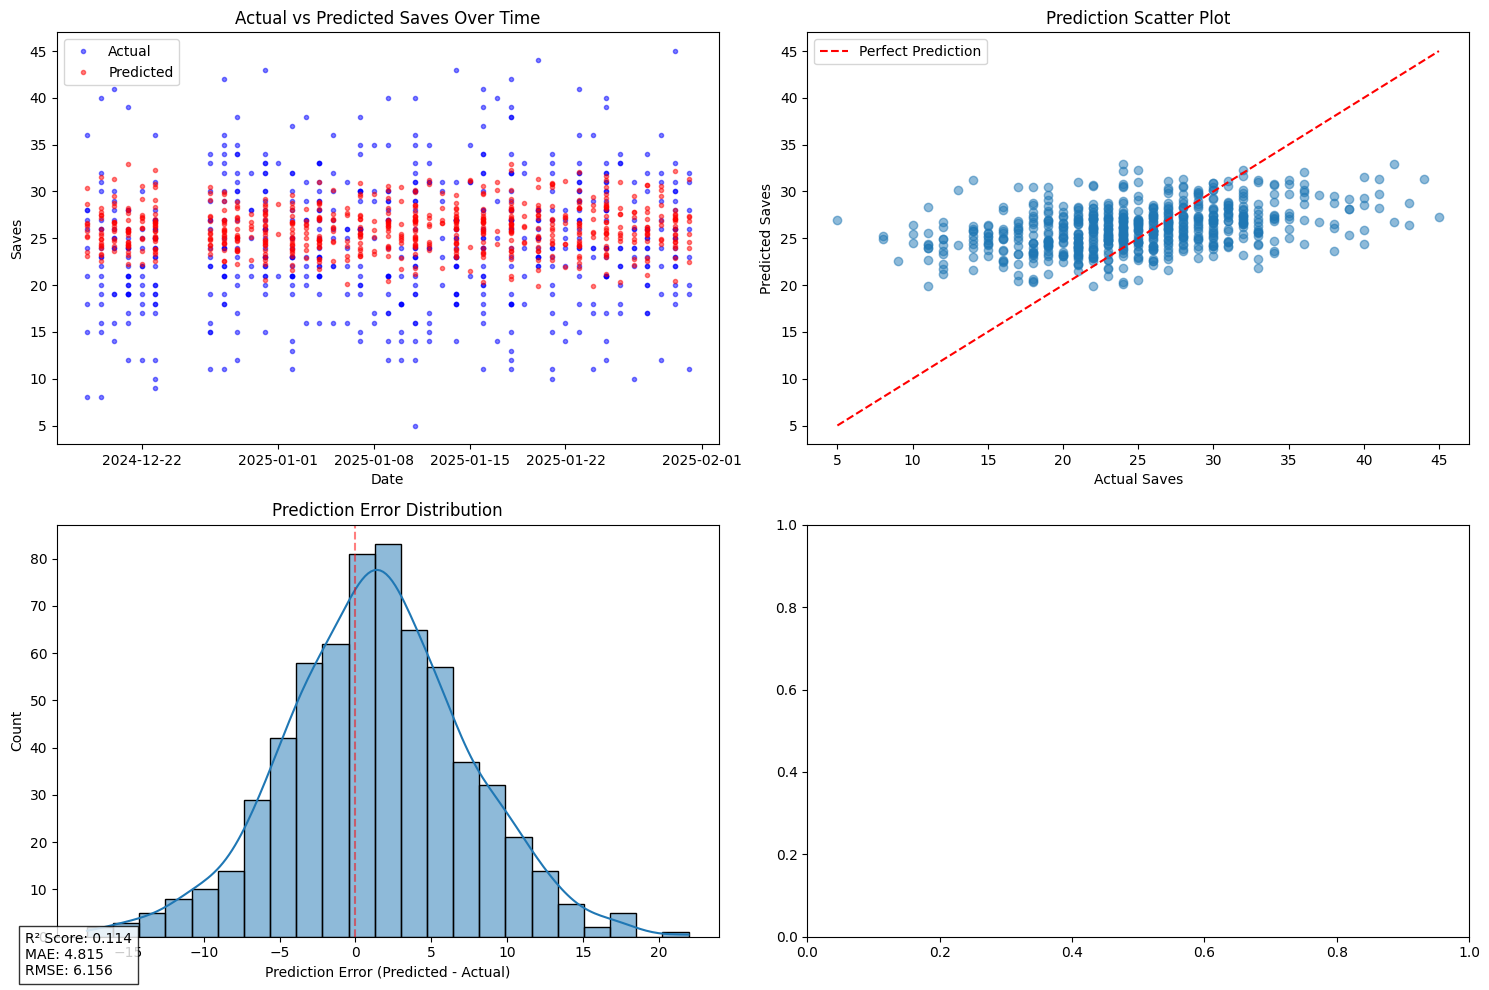


Error Statistics:
Mean Error: 1.348
Error Std Dev: 6.011
Error Range: [-17.703, 21.961]


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert game_date to datetime and sort
processed_df['game_date'] = pd.to_datetime(processed_df['game_date'])
processed_df = processed_df.sort_values('game_date')

# Define features and target
# Exclude all columns containing "res" from features and also exclude datetime columns
res_columns = [col for col in processed_df.columns if "res" in col]
# Convert 'home' to numeric (0/1)
processed_df['home'] = processed_df['home'].astype(int)
features = [col for col in processed_df.columns if col not in res_columns + ['game_date', 'team', 'goalie_name', 'goalie_team', 'game_id', 'last_game_date']]
X = processed_df[features]
y = processed_df["res_sv"]

# Train-test split (time-based)
split_date = processed_df['game_date'].max() - pd.Timedelta(days=45)
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train initial Random Forest
rf_fs = RandomForestRegressor(n_estimators=100, random_state=42)
rf_fs.fit(X_train_scaled, y_train)

# Feature importance ranking
feature_importances = np.array(rf_fs.feature_importances_)
feature_names = np.array(X_train.columns)
sorted_idx = np.argsort(feature_importances)[::-1]

# Try different feature set sizes (5, 10, 15, all features)
best_r2 = -np.inf
best_features = None

for num_features in range(5, len(features)+1, 5):
    top_features = feature_names[sorted_idx[:num_features]]
    
    X_train_selected = X_train[top_features]
    X_test_selected = X_test[top_features]

    # Scale again after feature selection
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Train a new model with the selected features
    rf_model = RandomForestRegressor(
        n_estimators=500, max_depth=10, bootstrap=True,
        max_features='sqrt', min_samples_leaf=4, min_samples_split=10,
        random_state=42
    )
    rf_model.fit(X_train_scaled, y_train)
    y_pred = rf_model.predict(X_test_scaled)

    # Evaluate performance
    r2 = r2_score(y_test, y_pred)
    
    # Keep track of the best feature set
    if r2 > best_r2:
        best_r2 = r2
        best_features = top_features

print(f"Best R² Score: {best_r2:.4f} using features: {best_features}")

# Final model with best features
X_train_selected = X_train[best_features]
X_test_selected = X_test[best_features]
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)

rf_model.fit(X_train_scaled, y_train)
y_pred = rf_model.predict(X_test_scaled)

# Final Evaluation
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'feature_importance': dict(zip(best_features, rf_model.feature_importances_))
}

# Visualization (unchanged)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Time series plot
axes[0, 0].plot(processed_df[test_mask]['game_date'], y_test, 'b.', label='Actual', alpha=0.5)
axes[0, 0].plot(processed_df[test_mask]['game_date'], y_pred, 'r.', label='Predicted', alpha=0.5)
axes[0, 0].set_title('Actual vs Predicted Saves Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Saves')
axes[0, 0].legend()

# 2. Scatter plot with regression line
axes[0, 1].scatter(y_test, y_pred, alpha=0.5)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Saves')
axes[0, 1].set_ylabel('Predicted Saves')
axes[0, 1].set_title('Prediction Scatter Plot')
axes[0, 1].legend()

# 3. Error distribution
errors = y_pred - y_test
sns.histplot(errors, kde=True, ax=axes[1, 0])
axes[1, 0].axvline(x=0, color='r', linestyle='--', alpha=0.5)
axes[1, 0].set_title('Prediction Error Distribution')
axes[1, 0].set_xlabel('Prediction Error (Predicted - Actual)')
axes[1, 0].set_ylabel('Count')

# Metrics Text
metrics_text = f'R² Score: {metrics["r2_score"]:.3f}\nMAE: {metrics["mae"]:.3f}\nRMSE: {metrics["rmse"]:.3f}'
fig.text(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print error statistics
print("\nError Statistics:")
print(f"Mean Error: {errors.mean():.3f}")
print(f"Error Std Dev: {errors.std():.3f}")
print(f"Error Range: [{errors.min():.3f}, {errors.max():.3f}]")


Training data from 0 to 5485
Testing data from 5486 to 6123


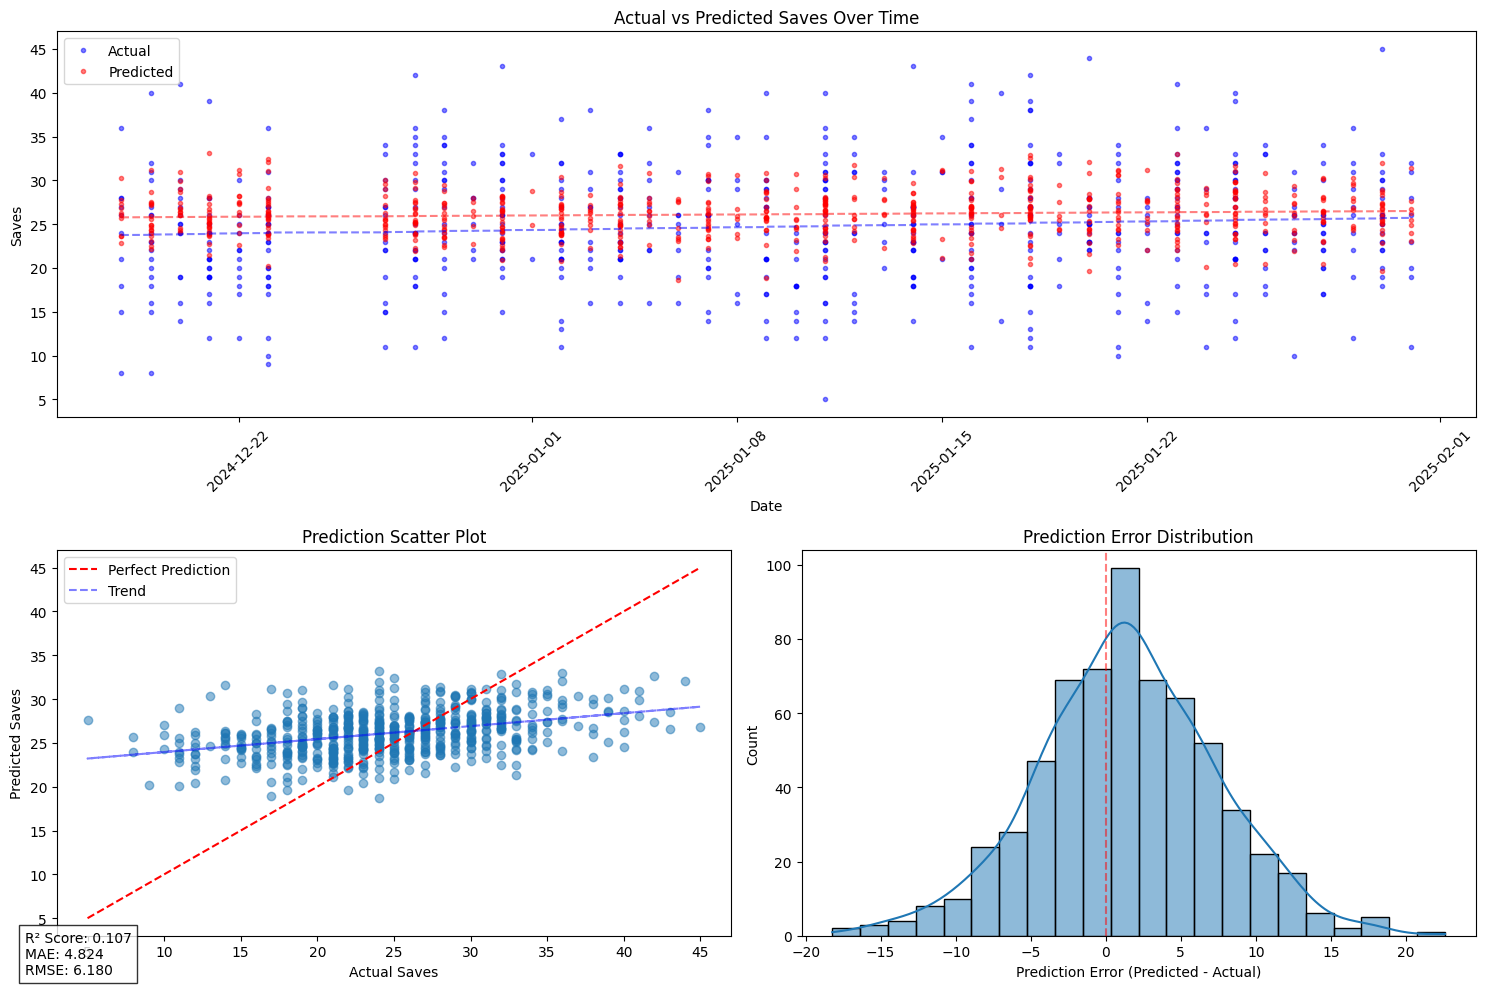


Error Statistics:
Mean Error: 1.404
Error Std Dev: 6.023
Error Range: [-18.226, 22.606]


In [15]:
"""Train the model on historical goalie data and return evaluation metrics"""
# Convert game_date to datetime and sort
processed_df['game_date'] = pd.to_datetime(processed_df['game_date'])
processed_df = processed_df.sort_values('game_date')

# Define base features without team dummies
features = [
'sf_pct', 'comp_sf', 'cf_pct', 'sh_pct', 'scsh_pct', 'ff_pct', 'g_sa_roll_avg',
'g_ld_sa_roll_std', 'pp_sh_pct', 'g_hd_sa_roll_avg', 'g_hd_sa_roll_std',
'g_md_sa_roll_avg', 'g_xg_against_roll_avg', 'g_sa_roll_std',
'g_md_sa_roll_std'
]

# Instead of random split, use time-based split
split_date = processed_df['game_date'].max() - pd.Timedelta(days=45)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

# Create team dummies and add them to the feature set
X = processed_df[features].copy()
# team_dummies = pd.get_dummies(processed_df['team'], prefix='team')
# X = pd.concat([X, team_dummies], axis=1)

# Split into train and test sets
X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_sv']
y_test = processed_df[test_mask]['res_sv']

print(f"Training data from {X_train.index.min()} to {X_train.index.max()}")
print(f"Testing data from {X_test.index.min()} to {X_test.index.max()}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    bootstrap=True,
    max_features='sqrt',
    min_samples_leaf=4,
    min_samples_split=10,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test_scaled)

# Calculate evaluation metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'feature_importance': dict(zip(X_train.columns, rf_model.feature_importances_))
}

# Create a figure with multiple subplots
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 2)

# 1. Time series plot (improved version)
ax1 = fig.add_subplot(gs[0, :])
ax1.plot(processed_df[test_mask]['game_date'], y_test, 'b.', label='Actual', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], y_pred, 'r.', label='Predicted', alpha=0.5)
# Add trend lines
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_test)), y_test, 1))(range(len(y_test))), 
         'b--', alpha=0.5)
ax1.plot(processed_df[test_mask]['game_date'], 
         np.poly1d(np.polyfit(range(len(y_pred)), y_pred, 1))(range(len(y_pred))), 
         'r--', alpha=0.5)
ax1.set_title('Actual vs Predicted Saves Over Time')
ax1.set_xlabel('Date')
ax1.set_ylabel('Saves')
ax1.legend()
ax1.tick_params(axis='x', rotation=45)

# 2. Scatter plot with regression line
ax2 = fig.add_subplot(gs[1, 0])
ax2.scatter(y_test, y_pred, alpha=0.5)
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax2.plot(y_test, p(y_test), "b--", alpha=0.5, label='Trend')
ax2.set_xlabel('Actual Saves')
ax2.set_ylabel('Predicted Saves')
ax2.set_title('Prediction Scatter Plot')
ax2.legend()

# 3. Error distribution
ax3 = fig.add_subplot(gs[1, 1])
errors = y_pred - y_test
sns.histplot(errors, kde=True, ax=ax3)
ax3.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax3.set_title('Prediction Error Distribution')
ax3.set_xlabel('Prediction Error (Predicted - Actual)')
ax3.set_ylabel('Count')

# Add metrics text box
metrics_text = f'R² Score: {metrics["r2_score"]:.3f}\nMAE: {metrics["mae"]:.3f}\nRMSE: {metrics["rmse"]:.3f}'
fig.text(0.02, 0.02, metrics_text, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

# Print additional statistical information
print("\nError Statistics:")
print(f"Mean Error: {errors.mean():.3f}")
print(f"Error Std Dev: {errors.std():.3f}")
print(f"Error Range: [{errors.min():.3f}, {errors.max():.3f}]")

Training set size: 5248 rows (85.7%)
Test set size: 876 rows (14.3%)
Training Random Forest model...


C:\Users\bills\AppData\Local\Temp\ipykernel_4572\2984989731.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train, X_test = X[train_mask], X[test_mask]
C:\Users\bills\AppData\Local\Temp\ipykernel_4572\2984989731.py:67: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train, X_test = X[train_mask], X[test_mask]



Model Performance:
Training RMSE: 5.0064
Training R² Score: 0.5295
Test RMSE: 6.3953
Test R² Score: 0.0276
Test MAE: 5.0725

Total execution time: 0.44 seconds

Feature importance:
          feature  importance
8   team_stat_pc1    0.252935
3              sf    0.153916
9   team_stat_pc2    0.126681
5          pp_toi    0.121869
10  team_stat_pc3    0.114620
4           pp_sf    0.108011
7          g_rest    0.056474
6            g_l7    0.025542
0            home    0.022019
2         opp_b2b    0.009054
1             b2b    0.008878


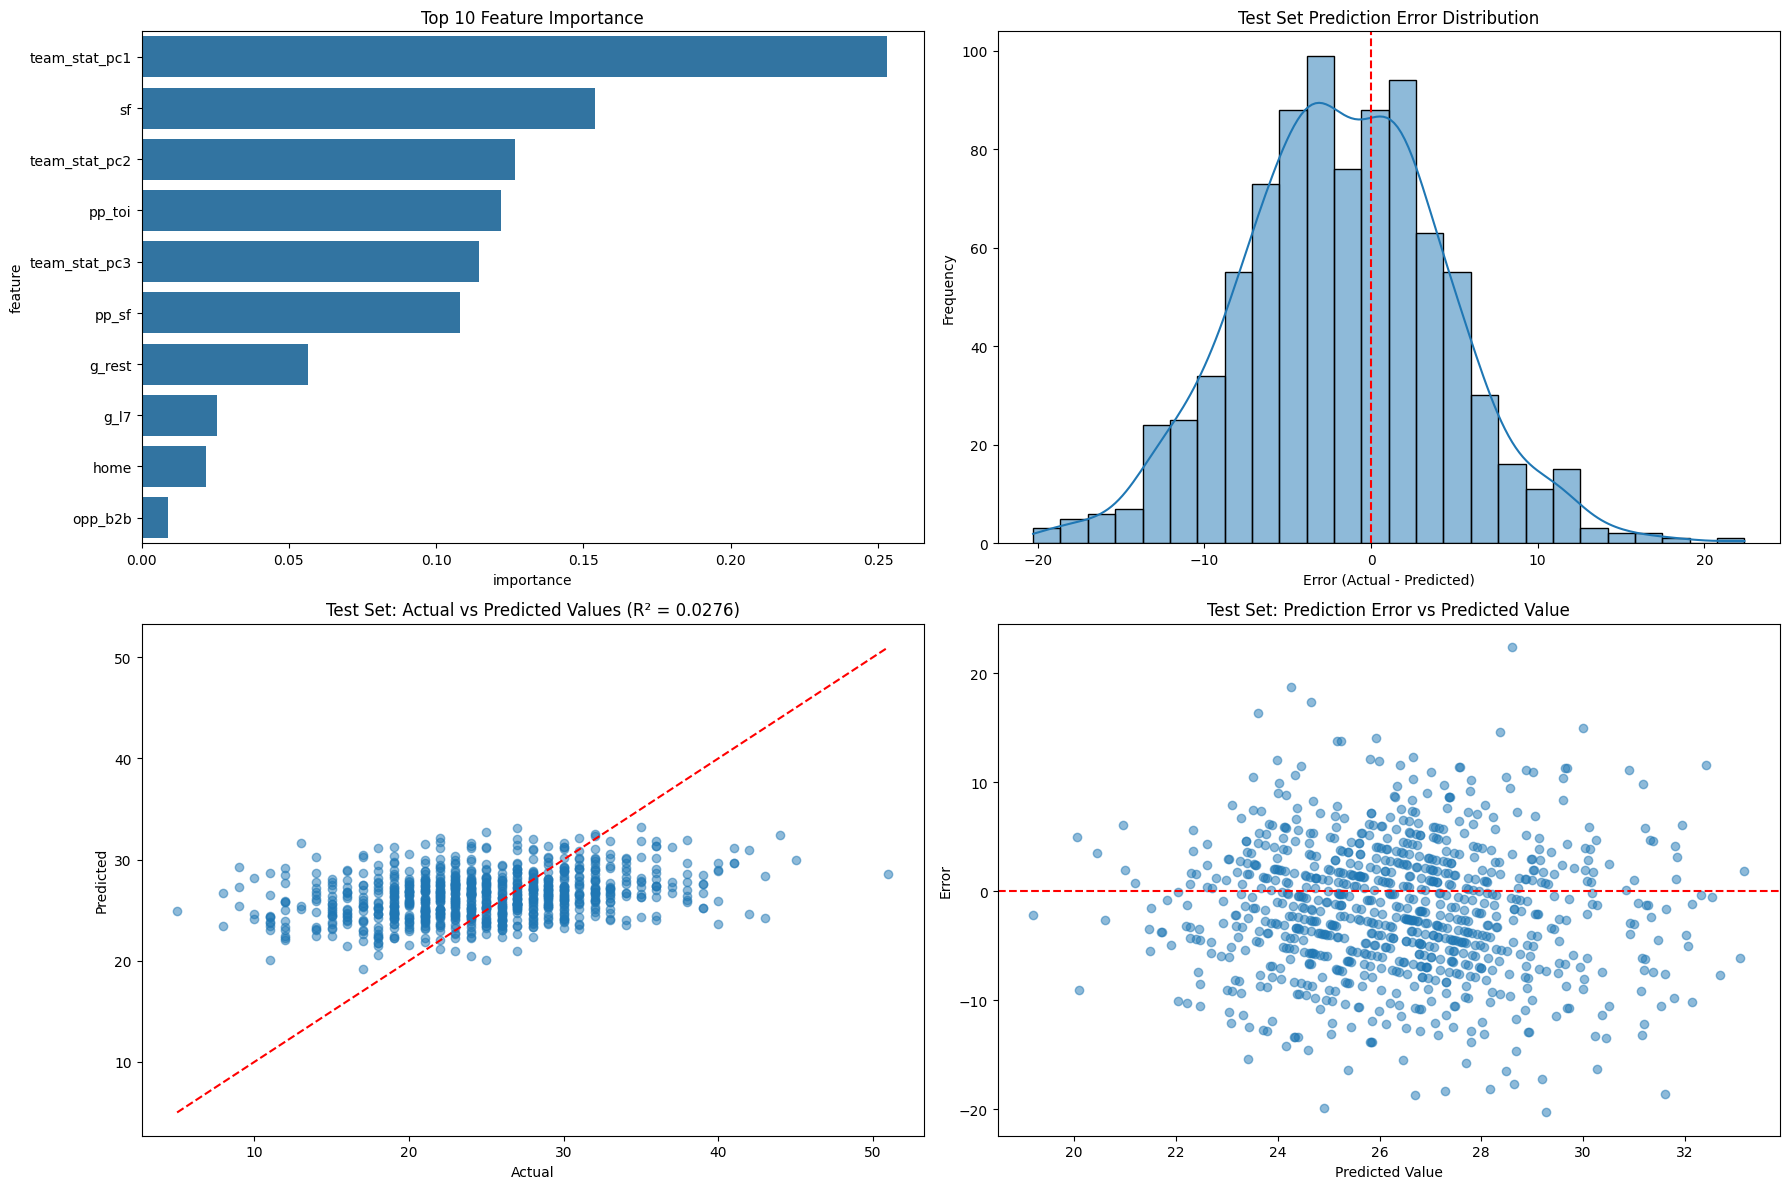


Test set error statistics:
Mean error: -1.6935
Median error: -1.7781
Standard deviation of error: 6.1706
Min error: -20.2777
Max error: 22.4024


In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Start timing
start_time = time.time()

# Identify the correlated team stats
team_stats = ['sf_pct', 'ff_pct', 'cf_pct', 'ldcf_pct', 'ldsf_pct', 
              'xgf_pct', 'scf_pct', 'scsf_pct', 'mdcf_pct', 'hdcf_pct']

# Apply PCA to reduce dimensions while preserving information
pca = PCA(n_components=3)  # Reduce to 3 components
team_stats_pca = pca.fit_transform(processed_df[team_stats])

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(
    team_stats_pca, 
    columns=['team_stat_pc1', 'team_stat_pc2', 'team_stat_pc3']
)

# Combine with other features
other_features = [
    'home', 'b2b', 'opp_b2b',
    # 'g_gsaa_roll_avg', 'g_sa_roll_avg', 'g_sa_roll_std',
    # 'g_sv_pct_roll_avg', 'g_sv_pct_roll_std',
    # 'g_hdsv_pct_roll_avg', 'g_mdsv_pct_roll_avg',
    'sf', 'pp_sf', 'pp_toi',
    'g_l7', 'g_rest'
]

# Create new feature set with PCA components
X_with_pca = pd.concat([processed_df[other_features].reset_index(drop=True), 
                        pca_df.reset_index(drop=True)], axis=1)

# Prepare the data
X = X_with_pca
y = processed_df['res_sv']

# Handle missing values
X = X.fillna(X.mean())

# Option 1: Random train-test split (if your data doesn't have a time component)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Option 2: Time-based split (similar to your XGBoost model)
# Uncomment these lines if you prefer a time-based split
# For a larger time-based split (e.g., last 60-90 days)
split_date = processed_df['game_date'].max() - pd.Timedelta(days=90)  # Adjust as needed

# Check the size of the resulting split
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

# Print split sizes to verify
print(f"Training set size: {sum(train_mask)} rows ({sum(train_mask)/len(processed_df)*100:.1f}%)")
print(f"Test set size: {sum(test_mask)} rows ({sum(test_mask)/len(processed_df)*100:.1f}%)")

# If the split looks good, proceed with it
X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize and train the Random Forest model with reasonable default parameters
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

print("Training Random Forest model...")
rf_model.fit(X_train_scaled, y_train)

# Calculate predictions and performance metrics for training data
y_train_pred = rf_model.predict(X_train_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

# Calculate predictions and performance metrics for test data
y_test_pred = rf_model.predict(X_test_scaled)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Training R² Score: {train_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Calculate prediction errors on test set
test_errors = y_test - y_test_pred

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

# Define the features list to match what was actually used in the model
features = other_features + ['team_stat_pc1', 'team_stat_pc2', 'team_stat_pc3']

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nFeature importance:")
print(feature_importance)

# Create a figure with multiple subplots
plt.figure(figsize=(18, 12))

# Plot 1: Feature importance
plt.subplot(2, 2, 1)
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Feature Importance')

# Plot 2: Prediction Error Distribution
plt.subplot(2, 2, 2)
sns.histplot(test_errors, kde=True)
plt.axvline(x=0, color='r', linestyle='--')
plt.title('Test Set Prediction Error Distribution')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')

# Plot 3: Actual vs Predicted
plt.subplot(2, 2, 3)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title(f'Test Set: Actual vs Predicted Values (R² = {test_r2:.4f})')
plt.xlabel('Actual')
plt.ylabel('Predicted')

# Plot 4: Error vs Predicted
plt.subplot(2, 2, 4)
plt.scatter(y_test_pred, test_errors, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Test Set: Prediction Error vs Predicted Value')
plt.xlabel('Predicted Value')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

# Print error statistics for test set
print("\nTest set error statistics:")
print(f"Mean error: {test_errors.mean():.4f}")
print(f"Median error: {np.median(test_errors):.4f}")
print(f"Standard deviation of error: {test_errors.std():.4f}")
print(f"Min error: {test_errors.min():.4f}")
print(f"Max error: {test_errors.max():.4f}")


Total number of parameter combinations: 16
Total number of fits: 48

Starting grid search...
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Best parameters found:
{'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.8}

Best score:
RMSE: 6.6444

Final Model Metrics:
R² Score: 0.141
MAE: 4.709
RMSE: 6.035


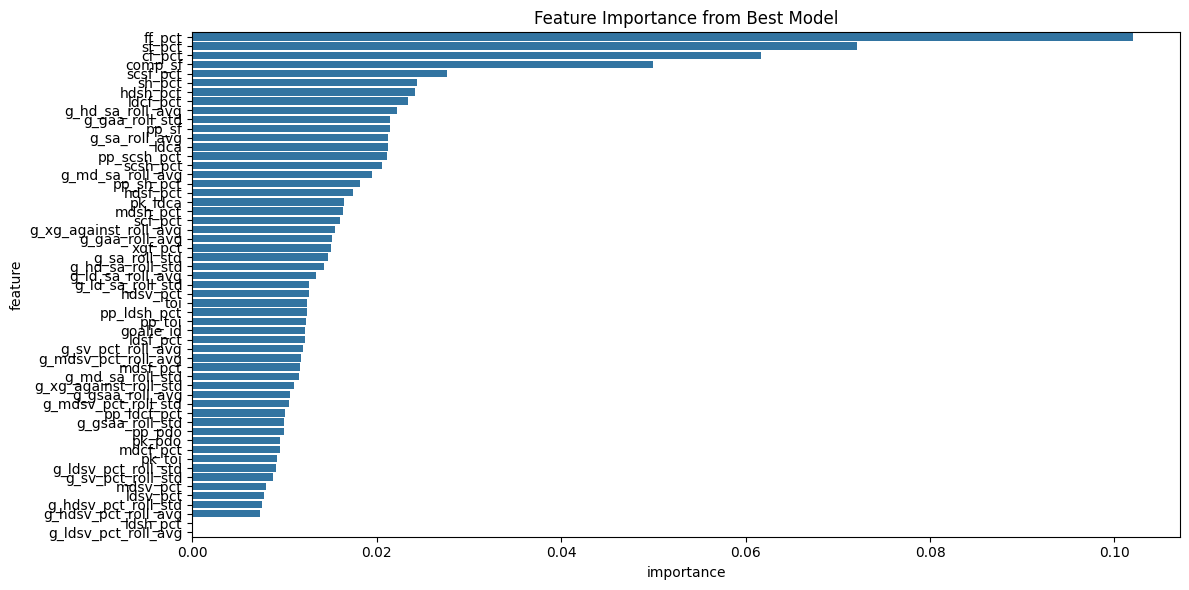

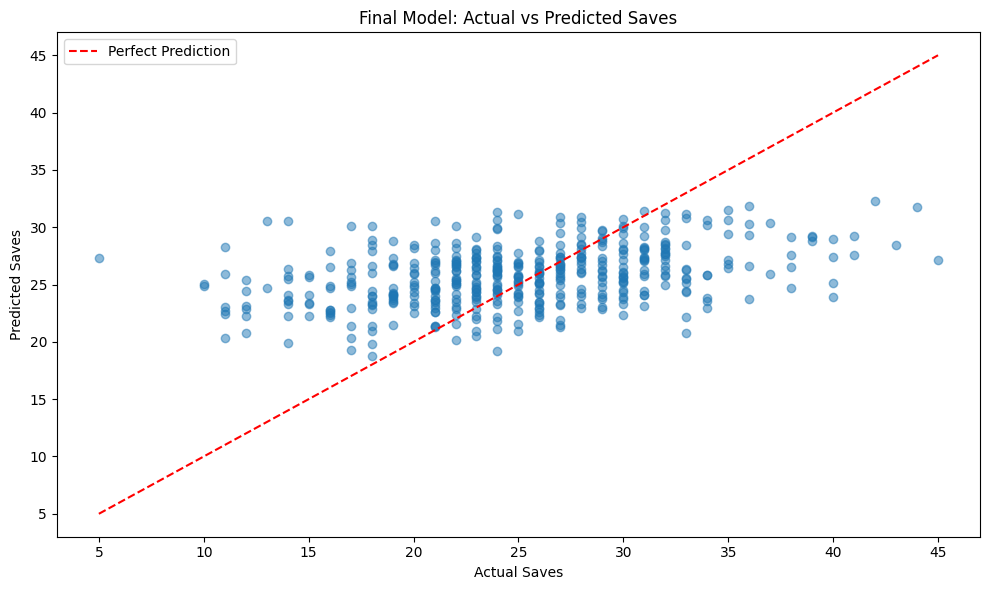

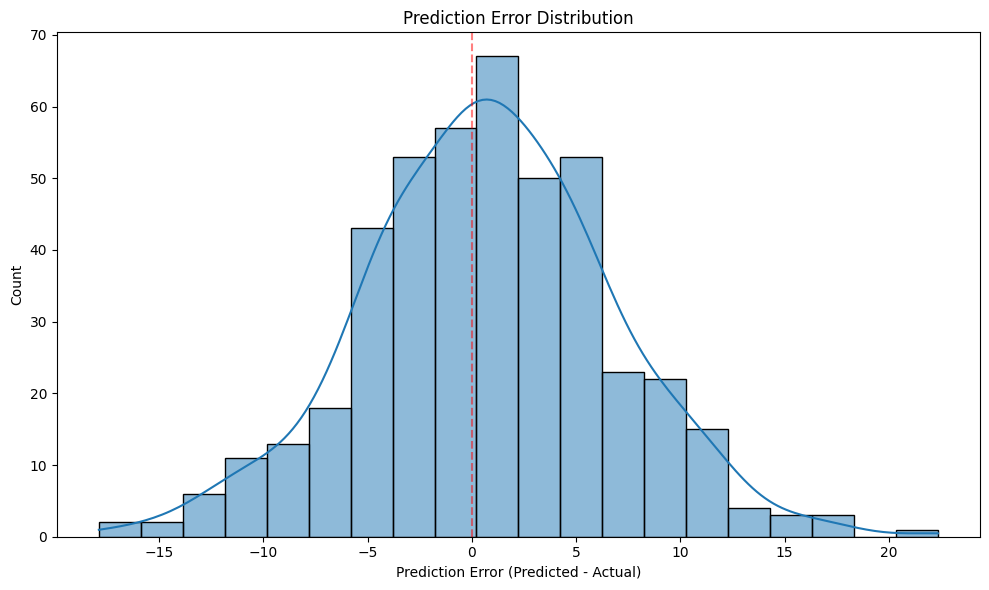


Total execution time: 14.62 seconds


In [20]:
# Import XGBoost
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import time

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
features = ['sf_pct', 'comp_sf', 'sh_pct', 'ff_pct', 'cf_pct', 'g_sa_roll_avg', 'scsh_pct',
 'g_ld_sa_roll_std', 'g_hd_sa_roll_avg', 'g_sa_roll_std', 'pp_sh_pct',
 'g_hd_sa_roll_std', 'g_hdsv_pct_roll_std', 'g_xg_against_roll_avg',
 'g_md_sa_roll_avg', 'g_md_sa_roll_std', 'g_xg_against_roll_std',
 'g_gsaa_roll_std', 'ldcf_pct', 'g_mdsv_pct_roll_avg', 'g_ld_sa_roll_avg',
 'pp_sf', 'pp_pdo', 'mdsh_pct', 'ldsf_pct', 'pp_toi', 'hdsh_pct',
 'g_mdsv_pct_roll_std', 'g_gaa_roll_std', 'goalie_id', 'g_hdsv_pct_roll_avg',
 'g_gaa_roll_avg', 'g_sv_pct_roll_std', 'pp_scsh_pct', 'g_ldsv_pct_roll_std',
 'mdsf_pct', 'scsf_pct', 'hdsv_pct', 'hdsf_pct', 'g_gsaa_roll_avg', 'mdcf_pct',
 'ldsh_pct', 'pk_pdo', 'pp_ldsh_pct', 'g_ldsv_pct_roll_avg',
 'g_sv_pct_roll_avg', 'ldsv_pct', 'pp_ldcf_pct', 'scf_pct', 'pk_toi', 'ldca',
 'mdsv_pct', 'xgf_pct', 'toi', 'pk_ldca']

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_sv']

# Handle missing values
X = X.fillna(X.mean())

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_sv']
y_test = processed_df[test_mask]['res_sv']

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a more focused parameter grid to reduce computation time
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1],
    'min_child_weight': [1, 3],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'gamma': [0],
    'reg_alpha': [0],
    'reg_lambda': [1.0]
}

# Initialize the model without early stopping
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Set up TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)  # Reduced from 5 to 3 for faster execution

# Calculate and print total number of combinations
n_combinations = np.prod([len(v) for v in param_grid.values()])
print(f"\nTotal number of parameter combinations: {n_combinations}")
print(f"Total number of fits: {n_combinations * 3}")  # 3 is the number of CV splits

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

print("\nStarting grid search...")
# Actually run the grid search
grid_search.fit(X_train_scaled, y_train)

# Print results
print("\nBest parameters found:")
print(grid_search.best_params_)

print("\nBest score:")
print(f"RMSE: {np.sqrt(-grid_search.best_score_):.4f}")

# Train final model with best parameters and early stopping
final_model = xgb.XGBRegressor(
    **grid_search.best_params_,
    random_state=42,
    early_stopping_rounds=20
)

# Fit final model with validation set for early stopping
final_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_test_scaled, y_test)],
    verbose=False
)

# Make predictions
y_pred = final_model.predict(X_test_scaled)

# Calculate metrics
final_metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred))
}

print("\nFinal Model Metrics:")
print(f"R² Score: {final_metrics['r2_score']:.3f}")
print(f"MAE: {final_metrics['mae']:.3f}")
print(f"RMSE: {final_metrics['rmse']:.3f}")

# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Best Model')
plt.tight_layout()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
plt.xlabel('Actual Saves')
plt.ylabel('Predicted Saves')
plt.title('Final Model: Actual vs Predicted Saves')
plt.legend()
plt.tight_layout()
plt.show()

# Plot prediction errors
errors = y_pred - y_test
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.title('Prediction Error Distribution')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

Training set size: 5678 samples
Test set size: 446 samples
Training voting ensemble model...

===== Model Evaluation Metrics =====

----- Regression Performance -----
R² Score: 0.1559
Explained Variance: 0.1657
Mean Absolute Error: 4.6536 saves
Median Absolute Error: 3.8626 saves
Root Mean Squared Error: 5.9834 saves
Maximum Error: 21.7927 saves

----- Error Distribution -----
Mean Error: 0.6439 saves
Error Standard Deviation: 5.9487
Error Skewness: 0.0284
Error Kurtosis: 0.3555
Normality Test p-value: 0.3092

----- Error Percentiles -----
Min Error: -18.2879 saves
25th Percentile: -3.3411 saves
Median Error: 0.7166 saves
75th Percentile: 4.4719 saves
Max Error: 21.7927 saves
Interquartile Range: 7.8130 saves

----- Prediction Accuracy -----
Predictions within ±1 saves: 16.14%
Predictions within ±2 saves: 28.92%
Predictions within ±3 saves: 39.46%
Predictions within ±5 saves: 62.33%


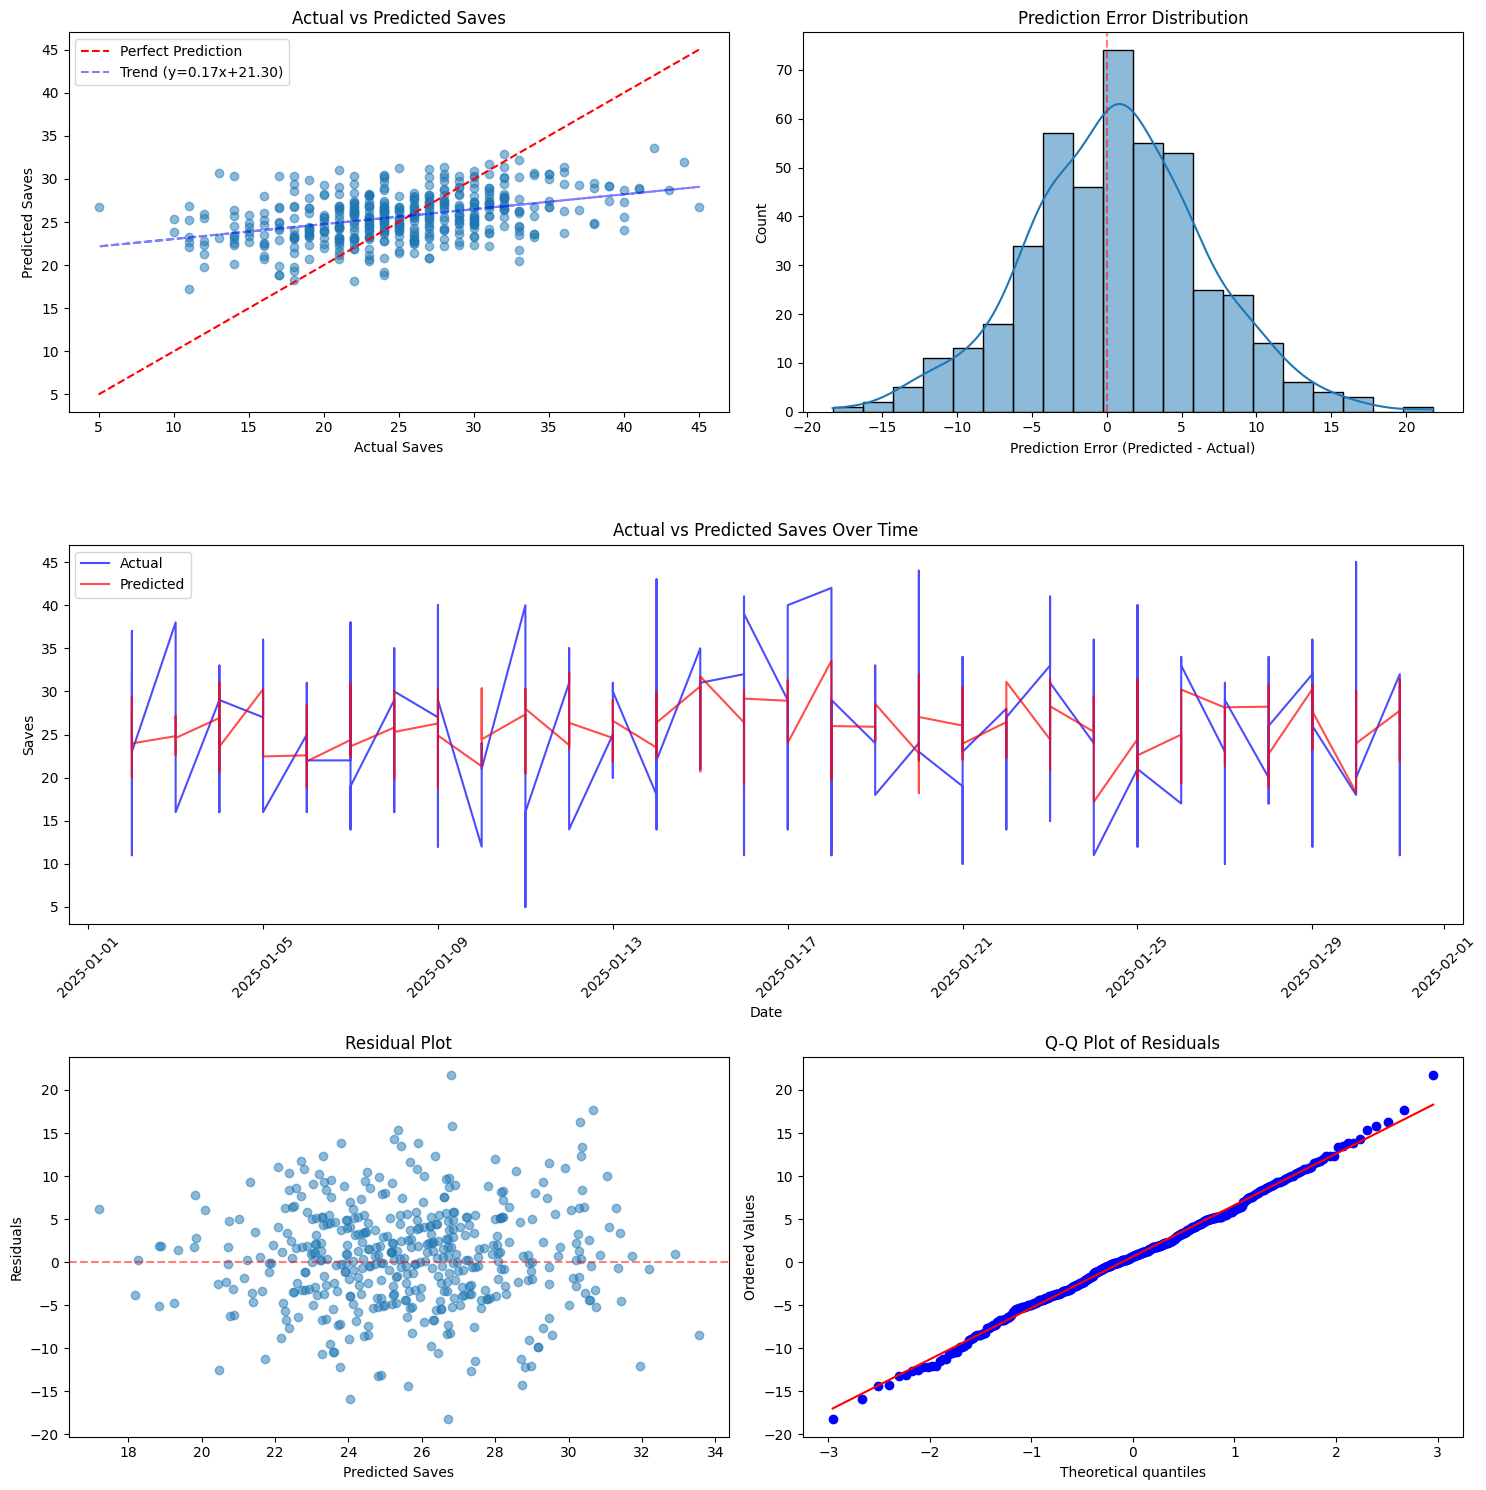

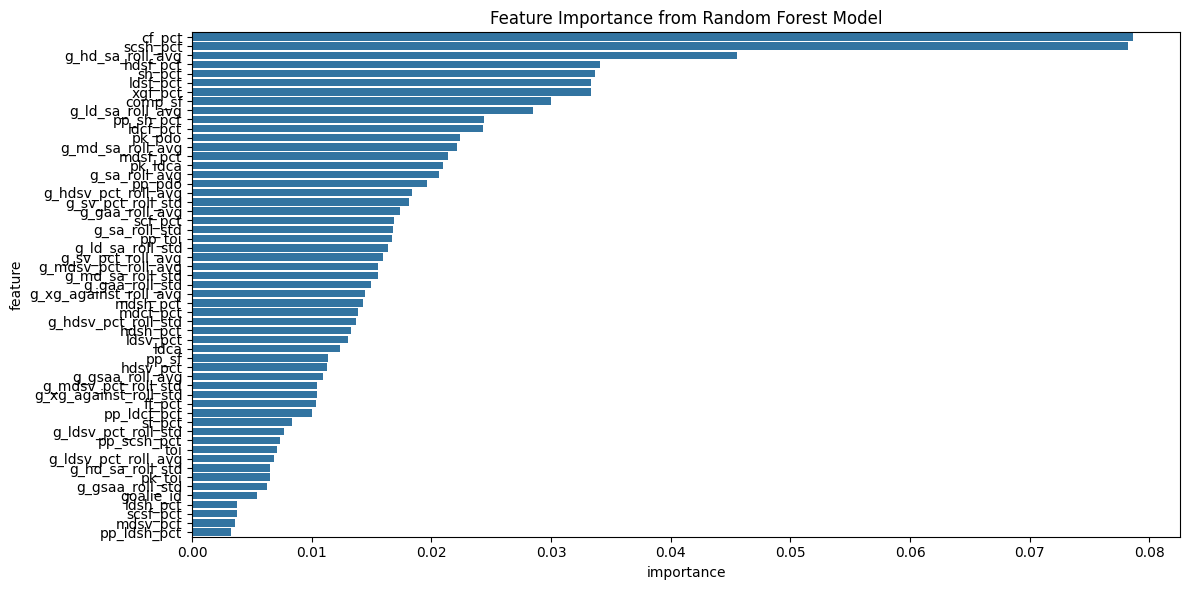


Total execution time: 25.67 seconds


In [21]:
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, explained_variance_score, median_absolute_error, max_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats

# Start timing
start_time = time.time()

# Define features (using the comprehensive set that performed well)
['sf_pct', 'comp_sf', 'sh_pct', 'ff_pct', 'cf_pct', 'g_sa_roll_avg', 'scsh_pct',
 'g_ld_sa_roll_std', 'g_hd_sa_roll_avg', 'g_sa_roll_std', 'pp_sh_pct',
 'g_hd_sa_roll_std', 'g_hdsv_pct_roll_std', 'g_xg_against_roll_avg',
 'g_md_sa_roll_avg', 'g_md_sa_roll_std', 'g_xg_against_roll_std',
 'g_gsaa_roll_std', 'ldcf_pct', 'g_mdsv_pct_roll_avg', 'g_ld_sa_roll_avg',
 'pp_sf', 'pp_pdo', 'mdsh_pct', 'ldsf_pct', 'pp_toi', 'hdsh_pct',
 'g_mdsv_pct_roll_std', 'g_gaa_roll_std', 'goalie_id', 'g_hdsv_pct_roll_avg',
 'g_gaa_roll_avg', 'g_sv_pct_roll_std', 'pp_scsh_pct', 'g_ldsv_pct_roll_std',
 'mdsf_pct', 'scsf_pct', 'hdsv_pct', 'hdsf_pct', 'g_gsaa_roll_avg', 'mdcf_pct',
 'ldsh_pct', 'pk_pdo', 'pp_ldsh_pct', 'g_ldsv_pct_roll_avg',
 'g_sv_pct_roll_avg', 'ldsv_pct', 'pp_ldcf_pct', 'scf_pct', 'pk_toi', 'ldca',
 'mdsv_pct', 'xgf_pct', 'toi', 'pk_ldca']

# Prepare the data
X = processed_df[features].copy()
y = processed_df['res_sv']

# Handle missing values
X = X.fillna(X.mean())

# Define train/test split based on time
split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)  # Use last 30 days as test set

# Create train/test sets based on date
train_mask = processed_df['game_date'] <= split_date
test_mask = processed_df['game_date'] > split_date

X_train = X[train_mask]
X_test = X[test_mask]
y_train = processed_df[train_mask]['res_sv']
y_test = processed_df[test_mask]['res_sv']

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Create base models
base_models = [
    ('rf', RandomForestRegressor(n_estimators=500, max_depth=10, bootstrap=True, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, random_state=42)),
    ('gbr', GradientBoostingRegressor(n_estimators=200, max_depth=5, random_state=42)),
    ('ridge', Ridge(alpha=1.0, random_state=42)),
    ('lasso', Lasso(alpha=0.01, random_state=42)),
    ('elasticnet', ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42))
]

# Create voting ensemble (simpler than stacking)
voting_model = VotingRegressor(
    estimators=base_models,
    weights=[0.3, 0.3, 0.2, 0.1, 0.1]  # Giving more weight to tree-based models
)

# Create pipeline with scaling
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', voting_model)
])

# Train the model
print("Training voting ensemble model...")
pipeline.fit(X_train, y_train)

# Make predictions
y_pred = pipeline.predict(X_test)

# Calculate comprehensive metrics
metrics = {
    'r2_score': r2_score(y_test, y_pred),
    'explained_variance': explained_variance_score(y_test, y_pred),
    'mae': mean_absolute_error(y_test, y_pred),
    'median_ae': median_absolute_error(y_test, y_pred),
    'mse': mean_squared_error(y_test, y_pred),
    'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
    'max_error': max_error(y_test, y_pred),
    'mean_error': np.mean(y_pred - y_test),
    'std_error': np.std(y_pred - y_test)
}

# Calculate additional statistical metrics
errors = y_pred - y_test
metrics.update({
    'error_skewness': stats.skew(errors),
    'error_kurtosis': stats.kurtosis(errors),
    'error_normality_pvalue': stats.normaltest(errors)[1],
    'error_min': np.min(errors),
    'error_max': np.max(errors),
    'error_q1': np.percentile(errors, 25),
    'error_median': np.median(errors),
    'error_q3': np.percentile(errors, 75),
    'error_iqr': np.percentile(errors, 75) - np.percentile(errors, 25)
})

# Calculate percentage of predictions within different error margins
for margin in [1, 2, 3, 5]:
    metrics[f'within_{margin}_saves'] = np.mean(np.abs(errors) <= margin) * 100

# Print metrics in a formatted table
print("\n===== Model Evaluation Metrics =====")
print("\n----- Regression Performance -----")
print(f"R² Score: {metrics['r2_score']:.4f}")
print(f"Explained Variance: {metrics['explained_variance']:.4f}")
print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
print(f"Median Absolute Error: {metrics['median_ae']:.4f} saves")
print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
print(f"Maximum Error: {metrics['max_error']:.4f} saves")

print("\n----- Error Distribution -----")
print(f"Mean Error: {metrics['mean_error']:.4f} saves")
print(f"Error Standard Deviation: {metrics['std_error']:.4f}")
print(f"Error Skewness: {metrics['error_skewness']:.4f}")
print(f"Error Kurtosis: {metrics['error_kurtosis']:.4f}")
print(f"Normality Test p-value: {metrics['error_normality_pvalue']:.4f}")

print("\n----- Error Percentiles -----")
print(f"Min Error: {metrics['error_min']:.4f} saves")
print(f"25th Percentile: {metrics['error_q1']:.4f} saves")
print(f"Median Error: {metrics['error_median']:.4f} saves")
print(f"75th Percentile: {metrics['error_q3']:.4f} saves")
print(f"Max Error: {metrics['error_max']:.4f} saves")
print(f"Interquartile Range: {metrics['error_iqr']:.4f} saves")

print("\n----- Prediction Accuracy -----")
for margin in [1, 2, 3, 5]:
    print(f"Predictions within ±{margin} saves: {metrics[f'within_{margin}_saves']:.2f}%")

# Create a figure with multiple subplots for visualization
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(3, 2)

# 1. Actual vs Predicted scatter plot
ax1 = fig.add_subplot(gs[0, 0])
ax1.scatter(y_test, y_pred, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
ax1.plot(y_test, p(y_test), "b--", alpha=0.5, label=f'Trend (y={z[0]:.2f}x+{z[1]:.2f})')
ax1.set_xlabel('Actual Saves')
ax1.set_ylabel('Predicted Saves')
ax1.set_title('Actual vs Predicted Saves')
ax1.legend()

# 2. Error distribution histogram
ax2 = fig.add_subplot(gs[0, 1])
sns.histplot(errors, kde=True, ax=ax2)
ax2.axvline(x=0, color='r', linestyle='--', alpha=0.5)
ax2.set_title('Prediction Error Distribution')
ax2.set_xlabel('Prediction Error (Predicted - Actual)')
ax2.set_ylabel('Count')

# 3. Time series of actual vs predicted
ax3 = fig.add_subplot(gs[1, :])
# Get dates for test set
test_dates = processed_df.loc[test_mask, 'game_date']
ax3.plot(test_dates, y_test, 'b-', label='Actual', alpha=0.7)
ax3.plot(test_dates, y_pred, 'r-', label='Predicted', alpha=0.7)
ax3.set_title('Actual vs Predicted Saves Over Time')
ax3.set_xlabel('Date')
ax3.set_ylabel('Saves')
ax3.legend()
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45)

# 4. Residual plot
ax4 = fig.add_subplot(gs[2, 0])
ax4.scatter(y_pred, errors, alpha=0.5)
ax4.axhline(y=0, color='r', linestyle='--', alpha=0.5)
ax4.set_xlabel('Predicted Saves')
ax4.set_ylabel('Residuals')
ax4.set_title('Residual Plot')

# 5. QQ plot for normality check
ax5 = fig.add_subplot(gs[2, 1])
stats.probplot(errors, plot=ax5)
ax5.set_title('Q-Q Plot of Residuals')

plt.tight_layout()
plt.show()

# Feature importance from Random Forest model
rf_model = pipeline.named_steps['model'].estimators_[0][1]
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance, x='importance', y='feature')
plt.title('Feature Importance from Random Forest Model')
plt.tight_layout()
plt.show()

# Calculate execution time
execution_time = time.time() - start_time
print(f"\nTotal execution time: {execution_time:.2f} seconds")

Training set size: 5678 samples
Test set size: 446 samples
Using 60 features after engineering
Selected features:
  1. sf_pct
  2. sh_pct
  3. ff_pct
  4. cf_pct
  5. scsh_pct
  6. g_md_sa_roll_std
  7. ldcf_pct
  8. ldsf_pct
  9. scsf_pct
  10. hdsf_pct
  11. mdcf_pct
  12. pp_ldsh_pct
  13. scf_pct
  14. ldca
  15. xgf_pct
Training neural network for 200 epochs...
Progress: [==] 2/200 epochs - 0.2s elapsed, ~23.2s remaining
Train loss: 301.4314, Val loss: 147.9175
Progress: [==] 4/200 epochs - 0.5s elapsed, ~22.5s remaining
Train loss: 121.8881, Val loss: 59.2652
Progress: [==] 6/200 epochs - 0.7s elapsed, ~22.0s remaining
Train loss: 83.8474, Val loss: 45.8987
Progress: [==] 8/200 epochs - 0.9s elapsed, ~21.5s remaining
Train loss: 73.3788, Val loss: 43.8620
Progress: [==] 10/200 epochs - 1.1s elapsed, ~21.0s remaining
Train loss: 66.9808, Val loss: 41.0055
Progress: [==] 12/200 epochs - 1.3s elapsed, ~20.8s remaining
Train loss: 65.6947, Val loss: 40.2230
Progress: [==] 14/200 epoc

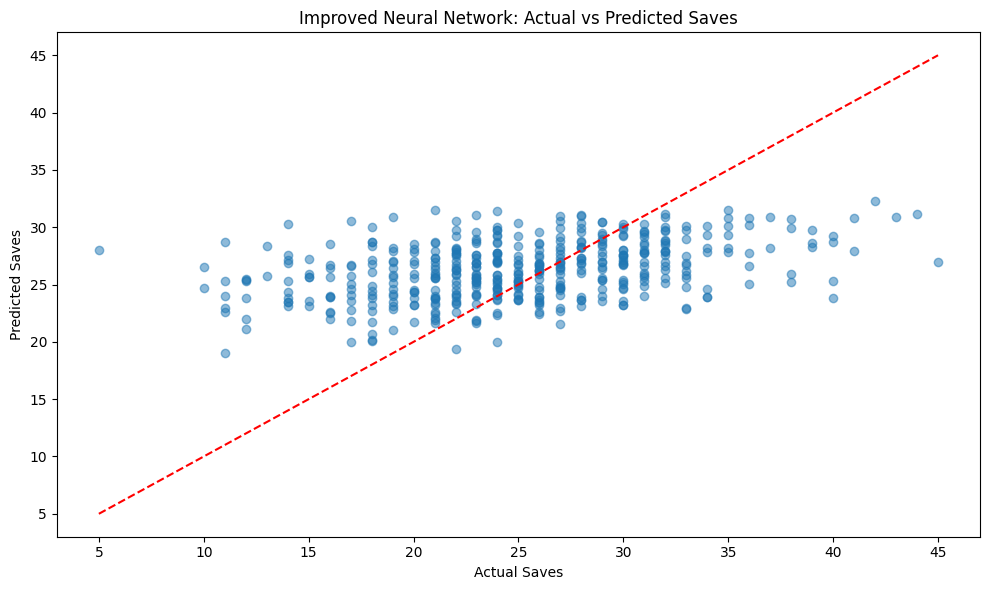

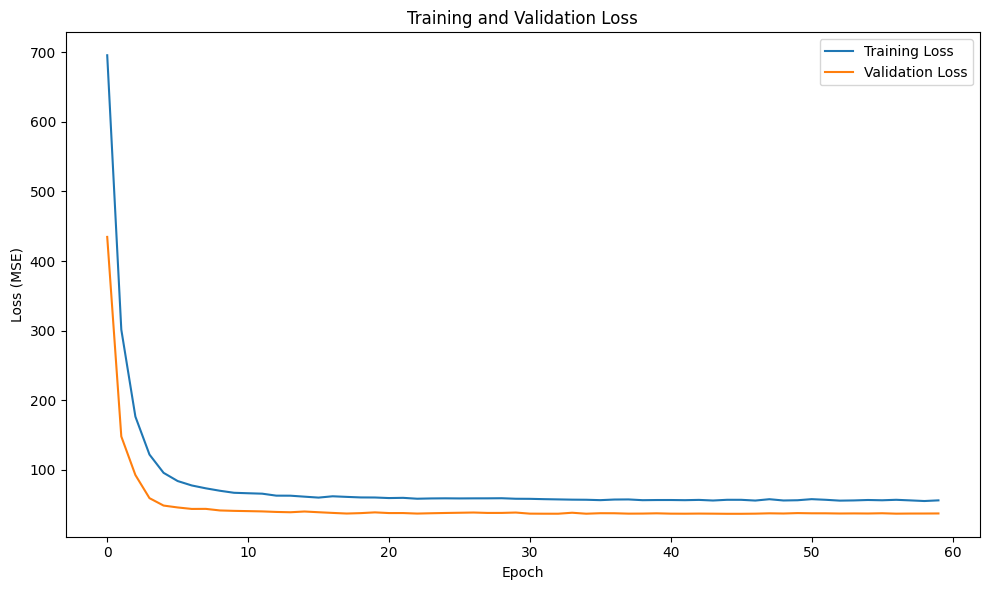


===== Improved Neural Network Model Evaluation =====
R² Score: 0.1203
Mean Absolute Error: 4.7591 saves
Root Mean Squared Error: 6.1084 saves
Predictions within ±1 saves: 14.35%
Predictions within ±2 saves: 26.68%
Predictions within ±3 saves: 40.81%
Predictions within ±5 saves: 61.43%


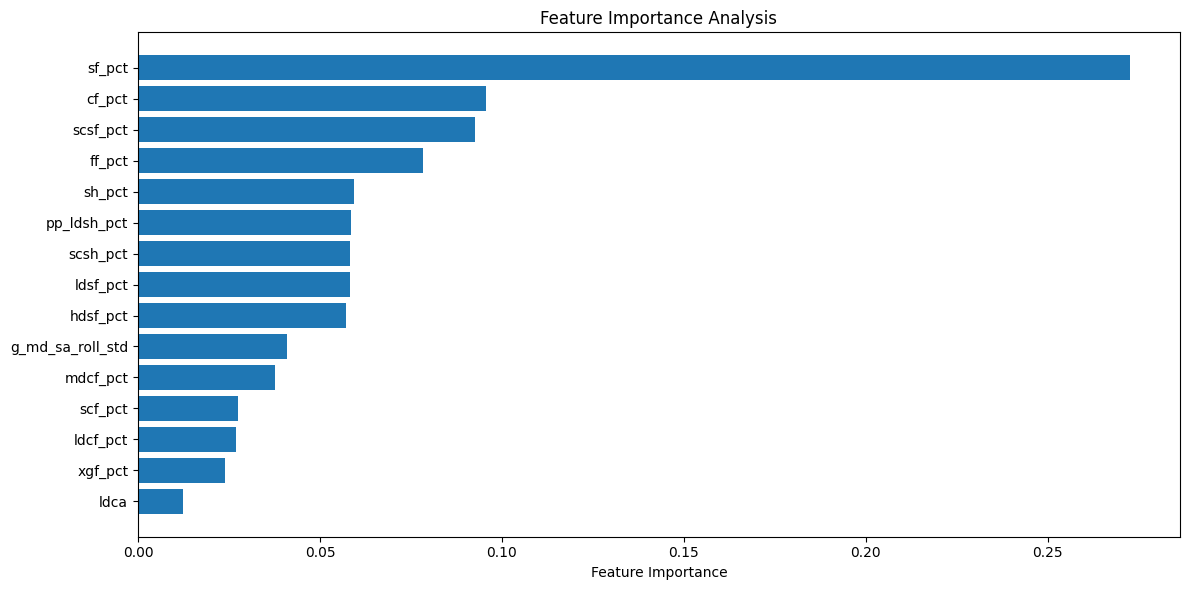

In [25]:


# Define a dataset class for our goalie data
class GoalieDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define a more complex neural network architecture
class GoalieNN(nn.Module):
    def __init__(self, input_size):
        super(GoalieNN, self).__init__()
        # More complex architecture with additional layers
        self.model = nn.Sequential(
            nn.Linear(input_size, 32),  # Larger first hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),  # Add dropout for regularization
            nn.Linear(32, 16),  # Add another hidden layer
            nn.ReLU(),
            nn.Dropout(0.1),  # Add dropout for regularization
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.model(x)

# Function to train the model with improved parameters
def train_nn_model_ultrafast(X_train, y_train, X_test, y_test, 
                             batch_size=64, epochs=200, learning_rate=0.001,
                             weight_decay=1e-5, patience=10):
    """
    Ultra-fast training function with improved parameters
    """
    # Start timing
    start_time = time.time()
    
    # Create datasets and dataloaders
    train_dataset = GoalieDataset(X_train, y_train)
    test_dataset = GoalieDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = GoalieNN(X_train.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Add learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)
    
    # Training loop
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    print(f"Training neural network for {epochs} epochs...")
    print(f"Progress: [", end="")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Quick validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Update learning rate based on validation loss
        scheduler.step(val_loss)
        
        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        # Print progress
        print("=", end="", flush=True)
        
        # Print detailed info every few epochs
        if (epoch + 1) % 2 == 0 or epoch == epochs - 1:
            elapsed = time.time() - start_time
            eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
            print(f"] {epoch+1}/{epochs} epochs - {elapsed:.1f}s elapsed, ~{eta:.1f}s remaining")
            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}")
            if epoch < epochs - 1:
                print(f"Progress: [", end="")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        y_pred = model(torch.tensor(X_test, dtype=torch.float32)).numpy().flatten()
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nTraining completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Function to run an improved neural network evaluation
def run_improved_goalie_nn():
    """
    Run an improved version of the neural network model with feature engineering
    """
    # Define base features using the new feature set
    base_features = [
        'sf_pct', 'comp_sf', 'sh_pct', 'ff_pct', 'cf_pct', 'g_sa_roll_avg',
        'scsh_pct', 'g_ld_sa_roll_std', 'g_hd_sa_roll_avg', 'g_sa_roll_std',
        'pp_sh_pct', 'g_hd_sa_roll_std', 'g_hdsv_pct_roll_std',
        'g_xg_against_roll_avg', 'g_md_sa_roll_avg', 'g_md_sa_roll_std',
        'g_xg_against_roll_std', 'g_gsaa_roll_std', 'ldcf_pct',
        'g_mdsv_pct_roll_avg', 'g_ld_sa_roll_avg', 'pp_sf', 'pp_pdo',
        'mdsh_pct', 'ldsf_pct', 'pp_toi', 'hdsh_pct', 'g_mdsv_pct_roll_std',
        'g_gaa_roll_std', 'g_hdsv_pct_roll_avg', 'g_gaa_roll_avg',
        'g_sv_pct_roll_std', 'pp_scsh_pct', 'g_ldsv_pct_roll_std',
        'mdsf_pct', 'scsf_pct', 'hdsv_pct', 'hdsf_pct', 'g_gsaa_roll_avg',
        'mdcf_pct', 'ldsh_pct', 'pk_pdo', 'pp_ldsh_pct',
        'g_ldsv_pct_roll_avg', 'g_sv_pct_roll_avg', 'ldsv_pct',
        'pp_ldcf_pct', 'scf_pct', 'pk_toi', 'ldca', 'mdsv_pct',
        'xgf_pct', 'toi', 'pk_ldca'
    ]

    # Prepare the data
    X = processed_df[base_features].copy()
    y = processed_df['res_sv']
    
    # Feature engineering - create meaningful interactions
    X['sv_danger_interaction'] = X['g_hdsv_pct_roll_avg'] * X['g_mdsv_pct_roll_avg'] * X['g_ldsv_pct_roll_avg']
    X['shots_danger_ratio'] = X['g_hd_sa_roll_avg'] / (X['g_md_sa_roll_avg'] + X['g_ld_sa_roll_avg']).replace(0, 0.001)
    X['pp_pk_time_ratio'] = X['pp_toi'] / X['pk_toi'].replace(0, 0.001)
    
    # Create polynomial features for key metrics
    X['gsaa_squared'] = X['g_gsaa_roll_avg'] ** 2
    X['sv_pct_squared'] = X['g_sv_pct_roll_avg'] ** 2
    
    # Create ratio features
    X['hd_md_sv_ratio'] = X['g_hdsv_pct_roll_avg'] / X['g_mdsv_pct_roll_avg'].replace(0, 0.001)
    
    # Handle missing values
    X = X.fillna(X.mean())

    # Define train/test split based on time
    split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)

    # Create train/test sets based on date
    train_mask = processed_df['game_date'] <= split_date
    test_mask = processed_df['game_date'] > split_date

    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = processed_df[train_mask]['res_sv']
    y_test = processed_df[test_mask]['res_sv']

    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Using {X_train.shape[1]} features after engineering")
    
    # Feature selection using mutual information
    from sklearn.feature_selection import SelectKBest, mutual_info_regression
    
    # Select top features (adjust k as needed)
    k = min(15, X_train.shape[1])
    selector = SelectKBest(mutual_info_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    # Get names of selected features
    selected_indices = selector.get_support(indices=True)
    selected_features = X_train.columns[selected_indices].tolist()
    
    print("Selected features:")
    for i, feature in enumerate(selected_features):
        print(f"  {i+1}. {feature}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    # Train the neural network with improved settings
    model, y_pred, metrics = train_nn_model_ultrafast(
        X_train_scaled, y_train, X_test_scaled, y_test,
        batch_size=64,
        epochs=200,
        learning_rate=0.001,
        weight_decay=1e-5,
        patience=15
    )
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Improved Neural Network: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\n===== Improved Neural Network Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = y_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    # Feature importance analysis
    if hasattr(model, 'feature_importances_'):
        # For tree-based models
        feature_importance = model.feature_importances_
    else:
        # For neural networks, use a simple sensitivity analysis
        feature_importance = []
        model.eval()
        with torch.no_grad():
            baseline = model(torch.tensor(X_test_scaled, dtype=torch.float32)).numpy().flatten()
            for i in range(X_test_scaled.shape[1]):
                # Perturb each feature and measure the effect
                X_perturbed = X_test_scaled.copy()
                X_perturbed[:, i] += 0.1 * X_perturbed[:, i].std()
                perturbed = model(torch.tensor(X_perturbed, dtype=torch.float32)).numpy().flatten()
                importance = np.mean(np.abs(perturbed - baseline))
                feature_importance.append(importance)
        
        # Normalize importances
        feature_importance = np.array(feature_importance) / sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    return model, scaler, metrics, selected_features

# Run the improved neural network model
improved_nn_model, improved_nn_scaler, improved_nn_metrics, selected_features = run_improved_goalie_nn()

Using device: cuda
GPU available: NVIDIA GeForce RTX 3080
GPU memory: 10.74 GB
Training set size: 5678 samples
Test set size: 446 samples
Using 65 features after engineering
Selected features:
  1. g_md_sa_roll_std
  2. mdsh_pct
  3. hdsh_pct
  4. pp_sf
  5. ldca
  6. scsh_pct
  7. mdsf_pct
  8. sh_pct
  9. comp_sf
  10. hdsf_pct
  11. ldsf_pct
  12. scsf_pct
  13. mdcf_pct
  14. xgf_pct
  15. scf_pct
  16. ldcf_pct
  17. ff_pct
  18. cf_pct
  19. team_offense_defense
  20. sf_pct

===== Training Single Neural Network =====


C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Training neural network for 300 epochs...
Progress: [==

C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


===] 5/300 epochs - 2.1s elapsed, ~124.7s remaining
Train loss: 25.1363, Val loss: 23.1580, LR: 0.000505
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 10/300 epochs - 2.8s elapsed, ~81.9s remaining
Train loss: 24.2128, Val loss: 22.5189, LR: 0.001000
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 15/300 epochs - 3.5s elapsed, ~67.2s remaining
Train loss: 20.7115, Val loss: 18.4627, LR: 0.000855
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 20/300 epochs - 4.2s elapsed, ~59.4s remaining
Train loss: 16.4077, Val loss: 14.2077, LR: 0.000505
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 25/300 epochs - 5.0s elapsed, ~54.6s remaining
Train loss: 13.9513, Val loss: 12.1824, LR: 0.000155
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 30/300 epochs - 5.7s elapsed, ~51.2s remaining
Train loss: 13.3570, Val loss: 11.7505, LR: 0.001000
GPU memory allocated

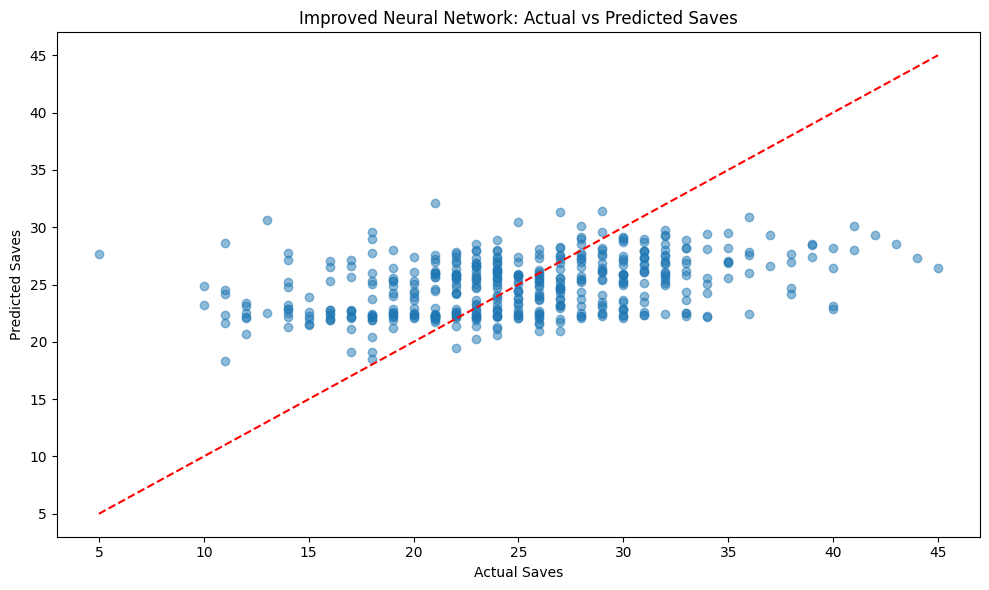

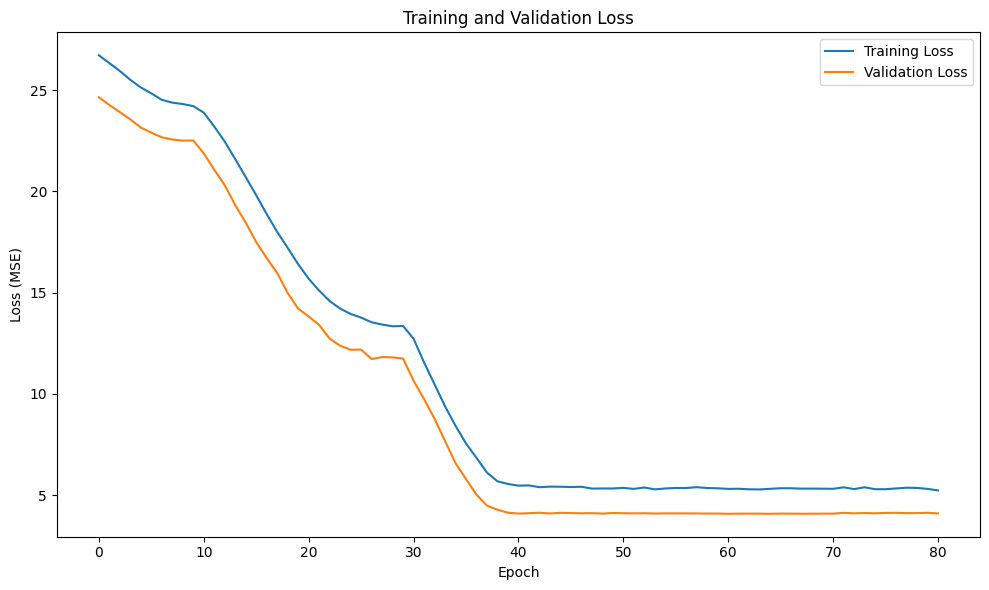


===== Improved Neural Network Model Evaluation =====
R² Score: 0.1520
Mean Absolute Error: 4.6901 saves
Root Mean Squared Error: 5.9972 saves
Predictions within ±1 saves: 13.68%
Predictions within ±2 saves: 25.78%
Predictions within ±3 saves: 40.36%
Predictions within ±5 saves: 63.00%


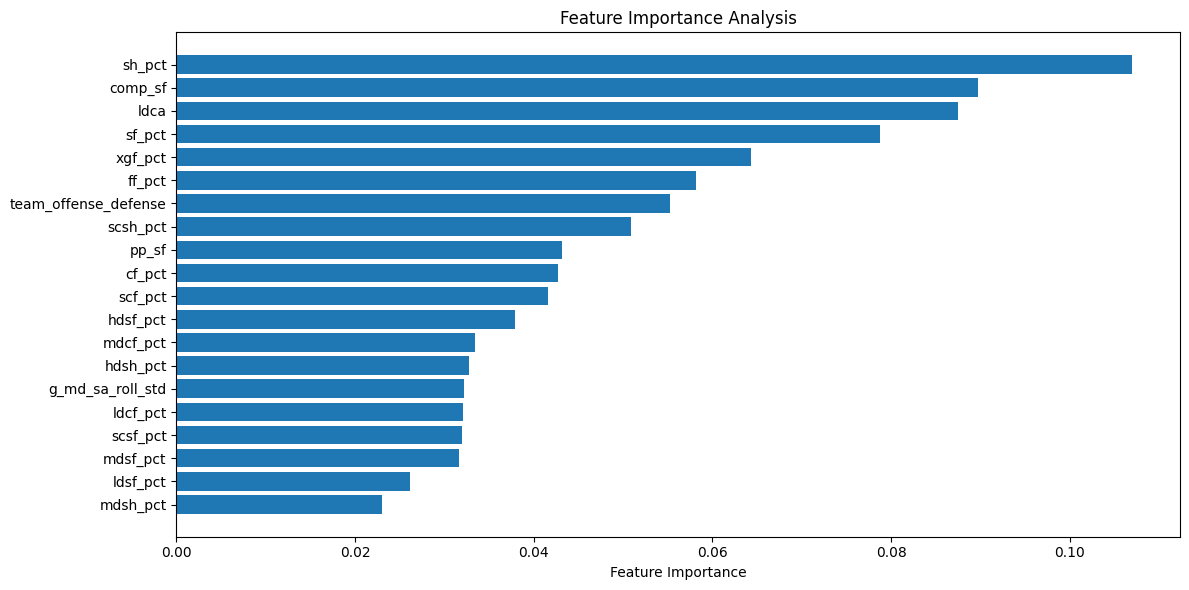


===== Creating Ensemble Model =====

Training model 1/5 for ensemble
Training neural network for 200 epochs...
Progress: [=

C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


====] 5/200 epochs - 0.8s elapsed, ~32.2s remaining
Train loss: 24.6599, Val loss: 22.4318, LR: 0.000505
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 10/200 epochs - 1.6s elapsed, ~30.1s remaining
Train loss: 23.5894, Val loss: 21.6461, LR: 0.001000
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 15/200 epochs - 2.3s elapsed, ~28.9s remaining
Train loss: 19.2665, Val loss: 16.9558, LR: 0.000855
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 20/200 epochs - 3.1s elapsed, ~28.3s remaining
Train loss: 14.1916, Val loss: 12.0093, LR: 0.000505
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 25/200 epochs - 3.9s elapsed, ~27.5s remaining
Train loss: 11.4768, Val loss: 9.8678, LR: 0.000155
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 30/200 epochs - 4.7s elapsed, ~26.5s remaining
Train loss: 10.7601, Val loss: 9.2652, LR: 0.001000
GPU memory allocated: 

C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


====] 5/200 epochs - 0.8s elapsed, ~30.7s remaining
Train loss: 24.8221, Val loss: 22.9168, LR: 0.000505
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 10/200 epochs - 1.6s elapsed, ~30.6s remaining
Train loss: 23.9232, Val loss: 22.0852, LR: 0.001000
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 15/200 epochs - 2.4s elapsed, ~29.9s remaining
Train loss: 19.9105, Val loss: 17.4192, LR: 0.000855
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 20/200 epochs - 3.2s elapsed, ~29.1s remaining
Train loss: 15.0427, Val loss: 12.9579, LR: 0.000505
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 25/200 epochs - 4.0s elapsed, ~28.2s remaining
Train loss: 12.3367, Val loss: 10.6792, LR: 0.000155
GPU memory allocated: 0.02 GB
GPU memory cached: 0.02 GB
Progress: [=====] 30/200 epochs - 4.8s elapsed, ~27.3s remaining
Train loss: 11.7115, Val loss: 10.1174, LR: 0.001000
GPU memory allocated

C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


====] 5/200 epochs - 0.8s elapsed, ~31.6s remaining
Train loss: 23.8716, Val loss: 22.5728, LR: 0.000505
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 10/200 epochs - 1.6s elapsed, ~30.2s remaining
Train loss: 22.7685, Val loss: 21.7496, LR: 0.001000
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 15/200 epochs - 2.4s elapsed, ~29.2s remaining
Train loss: 18.2799, Val loss: 16.7652, LR: 0.000855
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 20/200 epochs - 3.2s elapsed, ~28.4s remaining
Train loss: 13.1517, Val loss: 12.2277, LR: 0.000505
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 25/200 epochs - 3.9s elapsed, ~27.5s remaining
Train loss: 10.4966, Val loss: 9.9632, LR: 0.000155
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 30/200 epochs - 4.7s elapsed, ~26.8s remaining
Train loss: 9.8339, Val loss: 9.2876, LR: 0.001000
GPU memory allocated: 0

C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


====] 5/200 epochs - 0.8s elapsed, ~31.0s remaining
Train loss: 24.2988, Val loss: 22.3424, LR: 0.000505
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 10/200 epochs - 1.5s elapsed, ~29.4s remaining
Train loss: 23.2271, Val loss: 21.4523, LR: 0.001000
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 15/200 epochs - 2.3s elapsed, ~28.7s remaining
Train loss: 19.0379, Val loss: 16.8072, LR: 0.000855
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 20/200 epochs - 3.1s elapsed, ~28.0s remaining
Train loss: 13.9256, Val loss: 12.2009, LR: 0.000505
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 25/200 epochs - 3.9s elapsed, ~27.0s remaining
Train loss: 11.0300, Val loss: 9.8537, LR: 0.000155
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 30/200 epochs - 4.6s elapsed, ~26.2s remaining
Train loss: 10.3291, Val loss: 9.2981, LR: 0.001000
GPU memory allocated: 

C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:121: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:142: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\bills\AppData\Local\Temp\ipykernel_11668\3780919855.py:167: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


====] 5/200 epochs - 0.8s elapsed, ~31.6s remaining
Train loss: 24.2921, Val loss: 22.5348, LR: 0.000505
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 10/200 epochs - 1.6s elapsed, ~30.5s remaining
Train loss: 23.1750, Val loss: 21.5635, LR: 0.001000
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 15/200 epochs - 2.4s elapsed, ~29.0s remaining
Train loss: 18.6109, Val loss: 16.5245, LR: 0.000855
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 20/200 epochs - 3.1s elapsed, ~27.7s remaining
Train loss: 13.3989, Val loss: 11.6723, LR: 0.000505
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 25/200 epochs - 3.9s elapsed, ~27.0s remaining
Train loss: 10.5110, Val loss: 9.2488, LR: 0.000155
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 30/200 epochs - 4.6s elapsed, ~26.0s remaining
Train loss: 9.8308, Val loss: 8.7203, LR: 0.001000
GPU memory allocated: 0

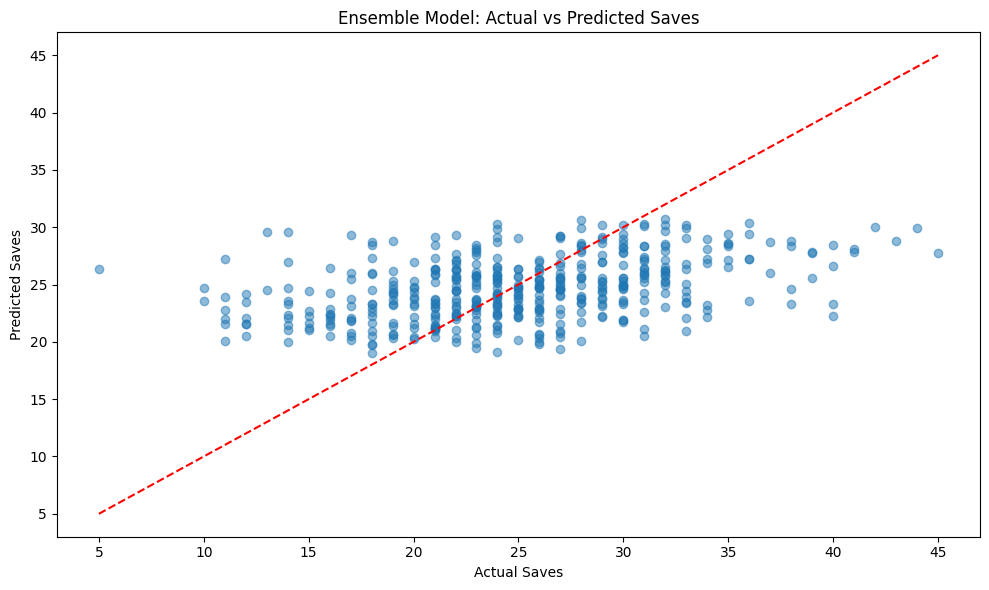


===== Single Model vs Ensemble Comparison =====
Single Model R²: 0.1520 | Ensemble R²: 0.1677
Single Model MAE: 4.6901 | Ensemble MAE: 4.6189
Single Model RMSE: 5.9972 | Ensemble RMSE: 5.9413


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from torch.cuda.amp import autocast, GradScaler

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enable CUDA benchmarking for performance optimization
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("No GPU available, using CPU")

# Function to monitor GPU memory usage
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

# Define a dataset class for our goalie data with GPU support
class GoalieDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1).to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define a more sophisticated neural network architecture
class GoalieNN(nn.Module):
    def __init__(self, input_size):
        super(GoalieNN, self).__init__()
        # More sophisticated architecture with batch normalization and residual connections
        self.bn_input = nn.BatchNorm1d(input_size)
        
        # First block
        self.fc1 = nn.Linear(input_size, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.3)
        
        # Second block
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.2)
        
        # Third block
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.dropout3 = nn.Dropout(0.1)
        
        # Output layer
        self.fc_out = nn.Linear(16, 1)
    
    def forward(self, x):
        # Input normalization
        x = self.bn_input(x)
        
        # First block
        x1 = F.leaky_relu(self.bn1(self.fc1(x)))
        x1 = self.dropout1(x1)
        
        # Second block
        x2 = F.leaky_relu(self.bn2(self.fc2(x1)))
        x2 = self.dropout2(x2)
        
        # Third block
        x3 = F.leaky_relu(self.bn3(self.fc3(x2)))
        x3 = self.dropout3(x3)
        
        # Output
        return self.fc_out(x3)

# Enhanced training function with GPU support and mixed precision
def train_nn_model_enhanced(X_train, y_train, X_test, y_test, 
                           batch_size=128, epochs=300, learning_rate=0.001,
                           weight_decay=1e-4, patience=20):
    """
    Enhanced training function with GPU support and mixed precision training
    """
    # Start timing
    start_time = time.time()
    
    # Create datasets and dataloaders
    train_dataset = GoalieDataset(X_train, y_train)
    test_dataset = GoalieDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = GoalieNN(X_train.shape[1]).to(device)
    
    # Use Huber loss for robustness to outliers
    criterion = nn.HuberLoss(delta=1.0)
    
    # Use AdamW optimizer for better weight decay handling
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Add cosine annealing scheduler for better convergence
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-5
    )
    
    # Initialize gradient scaler for mixed precision training
    scaler = GradScaler()
    
    # Training loop
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    print(f"Training neural network for {epochs} epochs...")
    print(f"Progress: [", end="")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            # Use mixed precision for forward pass
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # Scale the loss and call backward
            scaler.scale(loss).backward()
            
            # Unscale before gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Step and update scaler
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Update learning rate
        scheduler.step()
        
        # Early stopping logic with patience
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        # Print progress
        print("=", end="", flush=True)
        
        # Print detailed info every few epochs
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            elapsed = time.time() - start_time
            eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
            current_lr = optimizer.param_groups[0]['lr']
            print(f"] {epoch+1}/{epochs} epochs - {elapsed:.1f}s elapsed, ~{eta:.1f}s remaining")
            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, LR: {current_lr:.6f}")
            print_gpu_memory()  # Monitor GPU memory usage
            if epoch < epochs - 1:
                print(f"Progress: [", end="")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        # Test data is already on GPU from the dataset
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy().flatten()
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nTraining completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Create an ensemble of neural networks with GPU support
def create_ensemble_model(X_train, y_train, X_test, y_test):
    """
    Create an ensemble of neural networks with GPU support
    """
    # Number of models in ensemble
    n_models = 5
    predictions = np.zeros((X_test.shape[0], n_models))
    
    for i in range(n_models):
        print(f"\nTraining model {i+1}/{n_models} for ensemble")
        
        # Create a bootstrap sample
        indices = np.random.choice(X_train.shape[0], size=X_train.shape[0], replace=True)
        X_boot = X_train[indices]
        y_boot = y_train.iloc[indices]
        
        # Train model with different random seed
        torch.manual_seed(42 + i)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(42 + i)
            
        model, y_pred, _ = train_nn_model_enhanced(
            X_boot, y_boot, X_test, y_test,
            batch_size=128,
            epochs=200,  # Fewer epochs for each model
            learning_rate=0.001,
            weight_decay=1e-4,
            patience=15
        )
        
        # Store predictions
        predictions[:, i] = y_pred
    
    # Ensemble prediction (median for robustness)
    ensemble_pred = np.median(predictions, axis=1)
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, ensemble_pred),
        'mae': mean_absolute_error(y_test, ensemble_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, ensemble_pred))
    }
    
    print("\n===== Ensemble Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = ensemble_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    return ensemble_pred, metrics

# Run an improved version of the neural network model with GPU support
def run_improved_goalie_nn():
    """
    Run an improved version of the neural network model with GPU support
    """
    # Define base features using the new feature set
    base_features = [
        'sf_pct', 'comp_sf', 'sh_pct', 'ff_pct', 'cf_pct', 'g_sa_roll_avg',
        'scsh_pct', 'g_ld_sa_roll_std', 'g_hd_sa_roll_avg', 'g_sa_roll_std',
        'pp_sh_pct', 'g_hd_sa_roll_std', 'g_hdsv_pct_roll_std',
        'g_xg_against_roll_avg', 'g_md_sa_roll_avg', 'g_md_sa_roll_std',
        'g_xg_against_roll_std', 'g_gsaa_roll_std', 'ldcf_pct',
        'g_mdsv_pct_roll_avg', 'g_ld_sa_roll_avg', 'pp_sf', 'pp_pdo',
        'mdsh_pct', 'ldsf_pct', 'pp_toi', 'hdsh_pct', 'g_mdsv_pct_roll_std',
        'g_gaa_roll_std', 'g_hdsv_pct_roll_avg', 'g_gaa_roll_avg',
        'g_sv_pct_roll_std', 'pp_scsh_pct', 'g_ldsv_pct_roll_std',
        'mdsf_pct', 'scsf_pct', 'hdsv_pct', 'hdsf_pct', 'g_gsaa_roll_avg',
        'mdcf_pct', 'ldsh_pct', 'pk_pdo', 'pp_ldsh_pct',
        'g_ldsv_pct_roll_avg', 'g_sv_pct_roll_avg', 'ldsv_pct',
        'pp_ldcf_pct', 'scf_pct', 'pk_toi', 'ldca', 'mdsv_pct',
        'xgf_pct', 'toi', 'pk_ldca'
    ]

    # Prepare the data
    X = processed_df[base_features].copy()
    y = processed_df['res_sv']
    
    # Advanced feature engineering
    # 1. Create composite metrics
    X['danger_weighted_sv'] = (X['g_hdsv_pct_roll_avg'] * 3 + 
                              X['g_mdsv_pct_roll_avg'] * 2 + 
                              X['g_ldsv_pct_roll_avg']) / 6
    
    X['danger_weighted_shots'] = (X['g_hd_sa_roll_avg'] * 3 + 
                                 X['g_md_sa_roll_avg'] * 2 + 
                                 X['g_ld_sa_roll_avg']) / 6
    
    # 2. Create ratios and interactions
    X['hd_ld_ratio'] = X['g_hd_sa_roll_avg'] / X['g_ld_sa_roll_avg'].replace(0, 0.001)
    X['sv_consistency'] = X['g_sv_pct_roll_avg'] / (X['g_sv_pct_roll_std'] + 0.001)
    X['xg_efficiency'] = X['g_gsaa_roll_avg'] / (X['g_xg_against_roll_avg'] + 0.001)
    
    # 3. Create polynomial features for key metrics
    X['gsaa_squared'] = X['g_gsaa_roll_avg'] ** 2
    X['sv_pct_squared'] = X['g_sv_pct_roll_avg'] ** 2
    
    # 4. Create team performance interactions
    X['team_offense_defense'] = X['sf_pct'] * X['scf_pct']
    X['special_teams_effect'] = X['pp_toi'] * X['pp_pdo'] - X['pk_toi'] * X['pk_pdo']
    
    # 5. Create goalie workload metrics
    X['workload_intensity'] = X['g_sa_roll_avg'] * X['g_xg_against_roll_avg']
    X['danger_mix'] = X['g_hd_sa_roll_avg'] / (X['g_sa_roll_avg'] + 0.001)
    
    # Handle missing values with more sophisticated approach
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            # For percentage columns, fill with median
            if 'pct' in col or col.endswith('_pct'):
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(X[col].mean())
    
    # Define train/test split based on time
    split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)
    
    # Create train/test sets based on date
    train_mask = processed_df['game_date'] <= split_date
    test_mask = processed_df['game_date'] > split_date
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = processed_df[train_mask]['res_sv']
    y_test = processed_df[test_mask]['res_sv']
    
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Using {X_train.shape[1]} features after engineering")
    
    # Improved feature selection using a combination of methods
    # Use both mutual information and F-test for feature selection
    k = min(20, X_train.shape[1])  # Increase from 15 to 20 features
    
    # Mutual information selector
    mi_selector = SelectKBest(mutual_info_regression, k=k)
    mi_scores = mi_selector.fit(X_train, y_train).scores_
    
    # F-test selector
    f_selector = SelectKBest(f_regression, k=k)
    f_scores = f_selector.fit(X_train, y_train).scores_
    
    # Combine scores (normalize first)
    mi_scores = (mi_scores - mi_scores.min()) / (mi_scores.max() - mi_scores.min() + 1e-10)
    f_scores = (f_scores - f_scores.min()) / (f_scores.max() - f_scores.min() + 1e-10)
    combined_scores = mi_scores + f_scores
    
    # Select top features based on combined score
    top_indices = np.argsort(combined_scores)[-k:]
    
    # Get selected features
    X_train_selected = X_train.iloc[:, top_indices]
    X_test_selected = X_test.iloc[:, top_indices]
    selected_features = X_train.columns[top_indices].tolist()
    
    print("Selected features:")
    for i, feature in enumerate(selected_features):
        print(f"  {i+1}. {feature}")
    
    # Scale features with RobustScaler for better handling of outliers
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    # Train the neural network with enhanced settings
    print("\n===== Training Single Neural Network =====")
    model, y_pred, metrics = train_nn_model_enhanced(
        X_train_scaled, y_train, X_test_scaled, y_test,
        batch_size=128,  # Larger batch size for GPU
        epochs=300,
        learning_rate=0.001,
        weight_decay=1e-4,
        patience=20
    )
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Improved Neural Network: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\n===== Improved Neural Network Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = y_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    # Feature importance analysis using sensitivity analysis
    feature_importance = []
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
        baseline = model(X_test_tensor).cpu().numpy().flatten()
        for i in range(X_test_scaled.shape[1]):
            # Perturb each feature and measure the effect
            X_perturbed = X_test_scaled.copy()
            X_perturbed[:, i] += 0.1 * X_perturbed[:, i].std()
            X_perturbed_tensor = torch.tensor(X_perturbed, dtype=torch.float32).to(device)
            perturbed = model(X_perturbed_tensor).cpu().numpy().flatten()
            importance = np.mean(np.abs(perturbed - baseline))
            feature_importance.append(importance)
    
    # Normalize importances
    feature_importance = np.array(feature_importance) / sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    # Create ensemble model
    print("\n===== Creating Ensemble Model =====")
    ensemble_pred, ensemble_metrics = create_ensemble_model(
        X_train_scaled, y_train, X_test_scaled, y_test
    )
    
    # Plot ensemble predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, ensemble_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Ensemble Model: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Compare single model vs ensemble
    print("\n===== Single Model vs Ensemble Comparison =====")
    print(f"Single Model R²: {metrics['r2_score']:.4f} | Ensemble R²: {ensemble_metrics['r2_score']:.4f}")
    print(f"Single Model MAE: {metrics['mae']:.4f} | Ensemble MAE: {ensemble_metrics['mae']:.4f}")
    print(f"Single Model RMSE: {metrics['rmse']:.4f} | Ensemble RMSE: {ensemble_metrics['rmse']:.4f}")
    
    return {
        'single_model': model,
        'ensemble_pred': ensemble_pred,
        'scaler': scaler,
        'single_metrics': metrics,
        'ensemble_metrics': ensemble_metrics,
        'selected_features': selected_features
    }

# Run the improved neural network model with GPU support
results = run_improved_goalie_nn()

Python version: 3.9.7 (tags/v3.9.7:1016ef3, Aug 30 2021, 20:19:38) [MSC v.1929 64 bit (AMD64)]
PyTorch version: 2.6.0+cu118
CUDA available: True
CUDA version: 11.8
Number of CUDA devices: 1
CUDA Device 0: NVIDIA GeForce RTX 3080
Successfully created tensor on GPU: cuda:0
Using device: cuda
Adding advanced hockey-specific features...
Added 17 new features
Training set size: 5678 samples
Test set size: 446 samples
Using 71 features after engineering
Selected features:
  1. workload_intensity
  2. g_sa_roll_avg
  3. pp_sh_pct
  4. mdsh_pct
  5. pk_ldca
  6. pp_toi
  7. ldca
  8. g_md_sa_roll_std
  9. mdsf_pct
  10. hdsh_pct
  11. scsh_pct
  12. pp_sf
  13. comp_sf
  14. sh_pct
  15. hdsf_pct
  16. ldsf_pct
  17. scsf_pct
  18. mdcf_pct
  19. xgf_pct
  20. scf_pct
  21. ldcf_pct
  22. ff_pct
  23. team_defense_quality
  24. cf_pct
  25. sf_pct

===== Training Single Neural Network =====
Training neural network for 300 epochs...
Progress: [=====] 5/300 epochs - 1.0s elapsed, ~60.3s remainin

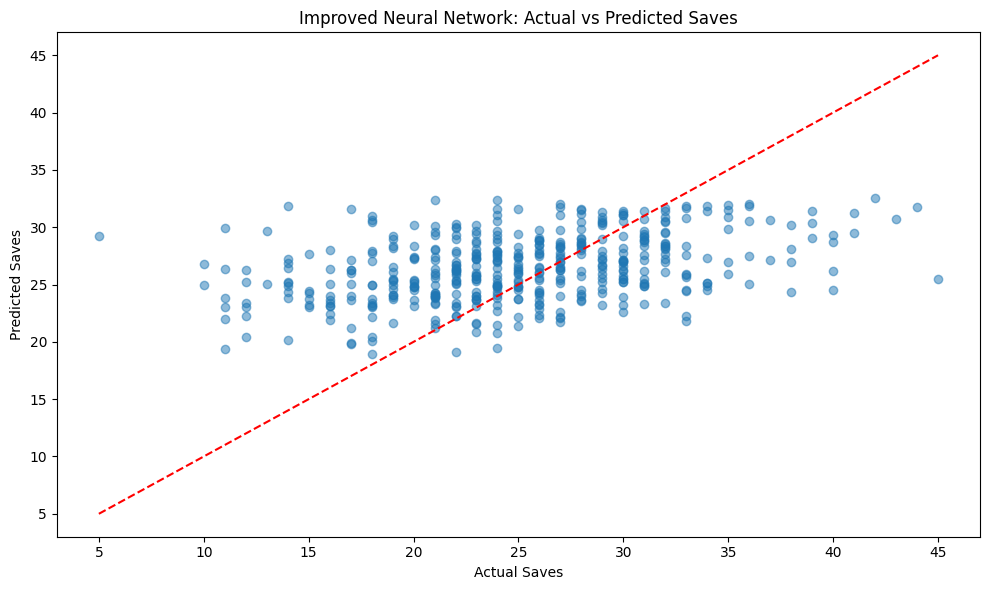

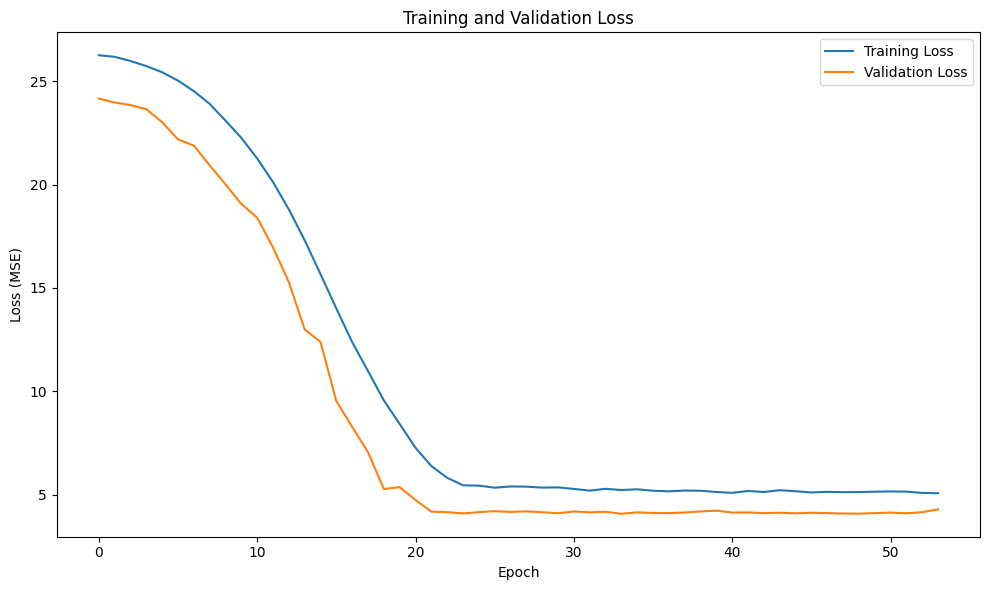


===== Improved Neural Network Model Evaluation =====
R² Score: 0.0965
Mean Absolute Error: 4.8432 saves
Root Mean Squared Error: 6.1904 saves
Predictions within ±1 saves: 13.00%
Predictions within ±2 saves: 26.23%
Predictions within ±3 saves: 39.01%
Predictions within ±5 saves: 62.56%


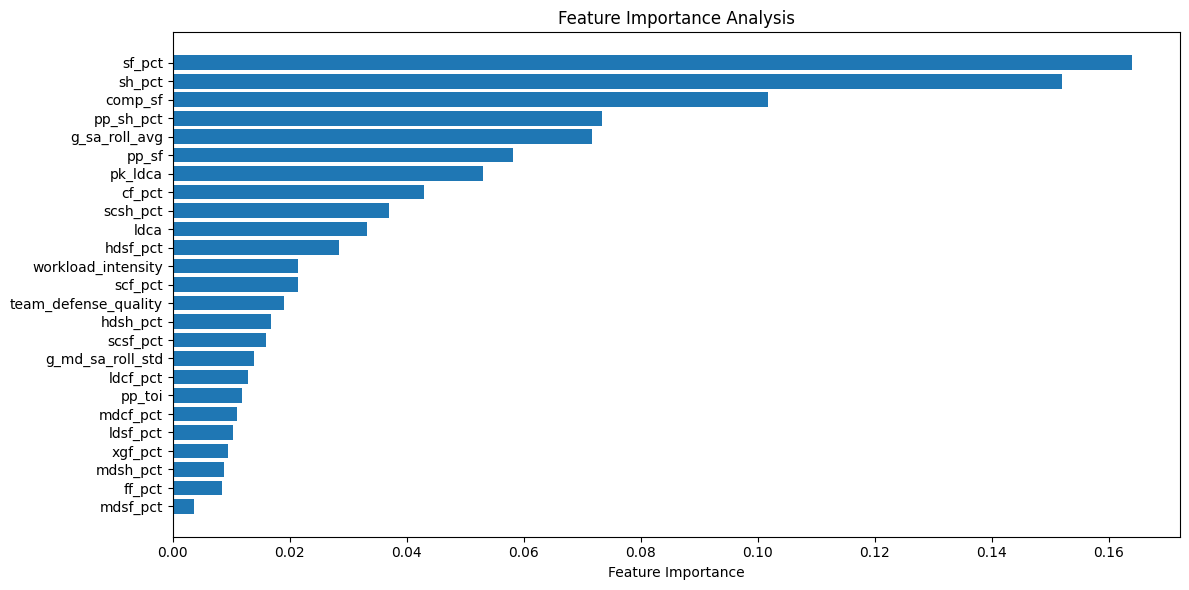


===== Creating Diverse Ensemble Model =====

===== Training Model 1: Standard Neural Network =====
Training neural network for 200 epochs...
Progress: [=====] 5/200 epochs - 1.0s elapsed, ~37.9s remaining
Train loss: 25.6477, Val loss: 23.8711, LR: 0.000564
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 10/200 epochs - 1.9s elapsed, ~35.7s remaining
Train loss: 20.8128, Val loss: 17.4192, LR: 0.001044
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 15/200 epochs - 2.8s elapsed, ~34.5s remaining
Train loss: 10.5329, Val loss: 7.3186, LR: 0.001807
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 20/200 epochs - 3.7s elapsed, ~33.5s remaining
Train loss: 5.4620, Val loss: 4.1860, LR: 0.002802
GPU memory allocated: 0.02 GB
GPU memory cached: 0.03 GB
Progress: [=====] 25/200 epochs - 4.7s elapsed, ~32.6s remaining
Train loss: 5.3565, Val loss: 4.1764, LR: 0.003960
GPU memory allocated: 0.02 GB
GPU memory cache

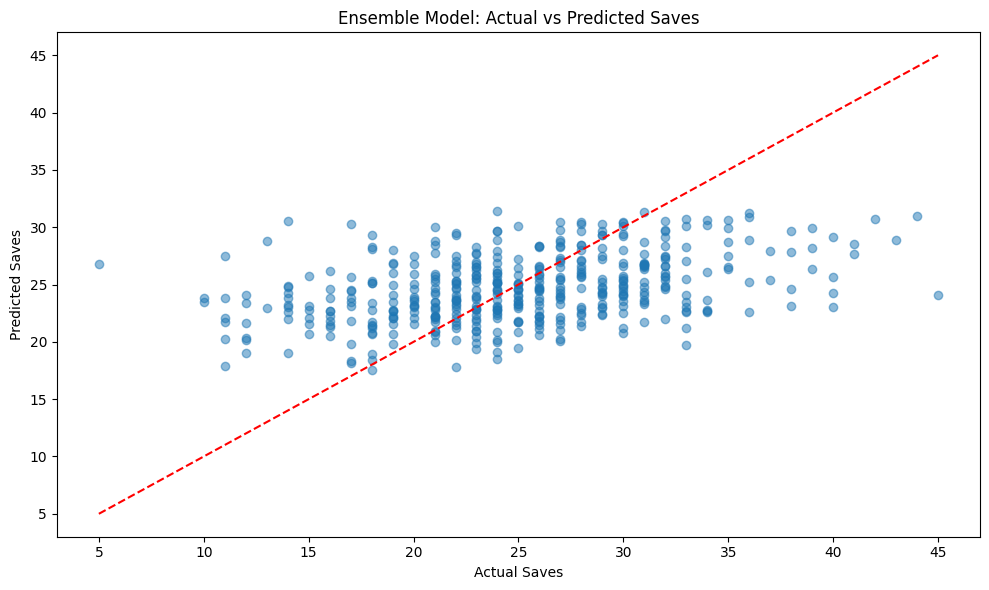


===== Single Model vs Ensemble Comparison =====
Single Model R²: 0.0965 | Ensemble R²: 0.1536
Single Model MAE: 4.8432 | Ensemble MAE: 4.6755
Single Model RMSE: 6.1904 | Ensemble RMSE: 5.9915


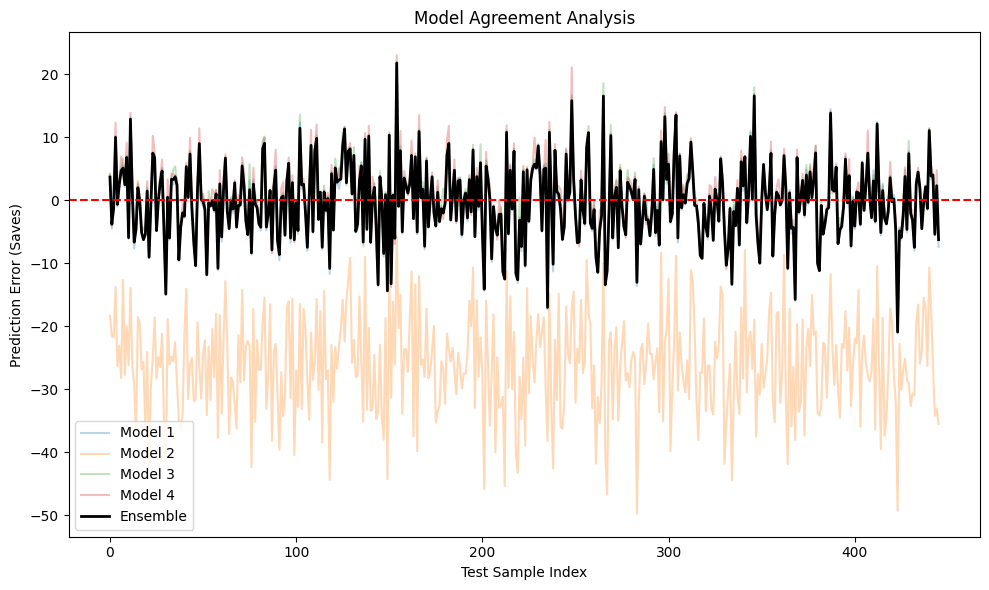


===== Final Model Performance Summary =====
Single Neural Network R²: 0.0965
Diverse Ensemble R²: 0.1536
Model saved as goalie_ensemble_model.pkl


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression
from torch.cuda.amp import autocast, GradScaler
import warnings
warnings.filterwarnings('ignore')

# Check for GPU availability and diagnose issues
import sys
print(f"Python version: {sys.version}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda if torch.cuda.is_available() else 'Not available'}")
print(f"Number of CUDA devices: {torch.cuda.device_count()}")

if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        print(f"CUDA Device {i}: {torch.cuda.get_device_name(i)}")
    # Try to force CUDA device
    try:
        test_tensor = torch.tensor([1.0]).cuda()
        print(f"Successfully created tensor on GPU: {test_tensor.device}")
    except Exception as e:
        print(f"Error when trying to use CUDA: {e}")
else:
    print("CUDA is not available. Possible reasons:")
    print("1. PyTorch was installed without CUDA support")
    print("2. NVIDIA drivers are not properly installed")
    print("3. Your GPU is not CUDA-compatible")
    print("4. CUDA toolkit version mismatch")
    
    # Check environment variables
    import os
    print("CUDA_VISIBLE_DEVICES:", os.environ.get("CUDA_VISIBLE_DEVICES", "Not set"))

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Enable CUDA benchmarking for performance optimization
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

# Function to monitor GPU memory usage
def print_gpu_memory():
    if torch.cuda.is_available():
        print(f"GPU memory allocated: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        print(f"GPU memory cached: {torch.cuda.memory_reserved() / 1e9:.2f} GB")

# Define a dataset class for our goalie data with GPU support
class GoalieDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).to(device)
        self.y = torch.tensor(y.values, dtype=torch.float32).reshape(-1, 1).to(device)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define an improved neural network with residual connections
class ImprovedGoalieNN(nn.Module):
    def __init__(self, input_size):
        super(ImprovedGoalieNN, self).__init__()
        # Input normalization
        self.bn_input = nn.BatchNorm1d(input_size)
        
        # Wider network with residual connections
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        
        # Residual block 1
        self.res1_fc1 = nn.Linear(64, 64)
        self.res1_bn1 = nn.BatchNorm1d(64)
        self.res1_fc2 = nn.Linear(64, 64)
        self.res1_bn2 = nn.BatchNorm1d(64)
        
        self.fc3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32)
        self.dropout3 = nn.Dropout(0.2)
        
        # Output layers
        self.fc_out = nn.Linear(32, 1)
    
    def forward(self, x):
        # Input normalization
        x = self.bn_input(x)
        
        # Initial layers
        x = F.selu(self.bn1(self.fc1(x)))  # SELU activation
        x = self.dropout1(x)
        
        x = F.selu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        
        # Residual block 1
        residual = x
        x = F.selu(self.res1_bn1(self.res1_fc1(x)))
        x = self.res1_bn2(self.res1_fc2(x))
        x = F.selu(x + residual)  # Add residual connection
        
        # Final layers
        x = F.selu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)
        
        return self.fc_out(x)

# Enhanced training function with GPU support and mixed precision
def train_nn_model_enhanced(X_train, y_train, X_test, y_test, 
                           batch_size=128, epochs=300, learning_rate=0.001,
                           weight_decay=1e-4, patience=20):
    """
    Enhanced training function with GPU support and mixed precision training
    """
    # Start timing
    start_time = time.time()
    
    # Create datasets and dataloaders
    train_dataset = GoalieDataset(X_train, y_train)
    test_dataset = GoalieDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Initialize model, loss function, and optimizer
    model = ImprovedGoalieNN(X_train.shape[1]).to(device)
    
    # Use Huber loss for robustness to outliers
    criterion = nn.HuberLoss(delta=1.0)
    
    # Use AdamW optimizer for better weight decay handling
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Add OneCycleLR scheduler for better convergence
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=0.01, epochs=epochs, steps_per_epoch=len(train_loader)
    )
    
    # Initialize gradient scaler for mixed precision training
    scaler = GradScaler()
    
    # Training loop
    train_losses = []
    val_losses = []
    best_model_state = None
    best_val_loss = float('inf')
    early_stopping_counter = 0
    
    print(f"Training neural network for {epochs} epochs...")
    print(f"Progress: [", end="")
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            
            # Use mixed precision for forward pass
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, targets)
            
            # Scale the loss and call backward
            scaler.scale(loss).backward()
            
            # Unscale before gradient clipping
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Step and update scaler
            scaler.step(optimizer)
            scaler.update()
            
            # Update learning rate
            scheduler.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in test_loader:
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        # Early stopping logic with patience
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            
        if early_stopping_counter >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break
        
        # Print progress
        print("=", end="", flush=True)
        
        # Print detailed info every few epochs
        if (epoch + 1) % 5 == 0 or epoch == epochs - 1:
            elapsed = time.time() - start_time
            eta = elapsed / (epoch + 1) * (epochs - epoch - 1)
            current_lr = optimizer.param_groups[0]['lr']
            print(f"] {epoch+1}/{epochs} epochs - {elapsed:.1f}s elapsed, ~{eta:.1f}s remaining")
            print(f"Train loss: {train_loss:.4f}, Val loss: {val_loss:.4f}, LR: {current_lr:.6f}")
            print_gpu_memory()  # Monitor GPU memory usage
            if epoch < epochs - 1:
                print(f"Progress: [", end="")
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        # Test data is already on GPU from the dataset
        X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy().flatten()
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, y_pred),
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nTraining completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Function to implement curriculum learning
def train_with_curriculum(X_train, y_train, X_test, y_test, epochs=400):
    """
    Implement curriculum learning - start with easier examples and gradually
    introduce harder ones
    """
    # Start timing
    start_time = time.time()
    
    # Check if inputs are pandas objects and convert if needed
    is_pandas_x = hasattr(X_train, 'iloc')
    is_pandas_y = hasattr(y_train, 'iloc')
    
    # Convert to numpy if they're pandas objects
    X_train_np = X_train if not is_pandas_x else X_train.values
    y_train_np = y_train if not is_pandas_y else y_train.values
    
    # Calculate error proxy - use standard deviation of target within similar feature space
    from sklearn.neighbors import NearestNeighbors as KNN
    
    print("Setting up curriculum learning...")
    # Find 20 nearest neighbors for each sample
    neighbors = KNN(n_neighbors=20)
    neighbors.fit(X_train_np)
    distances, indices = neighbors.kneighbors(X_train_np)
    
    # Calculate standard deviation of target within neighbors
    difficulty = []
    for idx_list in indices:
        if is_pandas_y:
            difficulty.append(np.std(y_train.iloc[idx_list]))
        else:
            difficulty.append(np.std(y_train[idx_list]))
    
    # Sort by difficulty
    difficulty = np.array(difficulty)
    sorted_indices = np.argsort(difficulty)
    
    # Create curriculum stages (4 stages of increasing difficulty)
    stage_size = len(sorted_indices) // 4
    stages = [
        sorted_indices[:stage_size],                      # Easiest 25%
        sorted_indices[:stage_size*2],                    # Easiest 50%
        sorted_indices[:stage_size*3],                    # Easiest 75%
        sorted_indices                                    # All data
    ]
    
    print("Starting curriculum training...")
    # Train with curriculum
    model = ImprovedGoalieNN(X_train_np.shape[1]).to(device)
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.HuberLoss(delta=1.0)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.01, epochs=epochs, steps_per_epoch=1)
    
    # Initialize for early stopping
    best_val_loss = float('inf')
    best_model_state = None
    early_stopping_counter = 0
    patience = 20
    
    # Training loop with curriculum
    print(f"Progress: [", end="")
    for epoch in range(epochs):
        model.train()
        
        # Determine which stage we're in
        stage_idx = min(epoch // (epochs // 4), 3)
        curr_indices = stages[stage_idx]
        
        # Create dataset for current stage - handle both pandas and numpy
        if is_pandas_x:
            X_curr = X_train.iloc[curr_indices].values
        else:
            X_curr = X_train_np[curr_indices]
            
        if is_pandas_y:
            y_curr = y_train.iloc[curr_indices].values
        else:
            y_curr = y_train_np[curr_indices]
        
        # Convert to tensors and move to device
        X_tensor = torch.tensor(X_curr, dtype=torch.float32).to(device)
        y_tensor = torch.tensor(y_curr, dtype=torch.float32).reshape(-1, 1).to(device)
        
        # Forward and backward pass
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Validation every 10 epochs
        if epoch % 10 == 0:
            model.eval()
            with torch.no_grad():
                # Handle both pandas and numpy for test data
                if hasattr(X_test, 'values'):
                    X_test_np = X_test.values
                else:
                    X_test_np = X_test
                    
                if hasattr(y_test, 'values'):
                    y_test_np = y_test.values
                else:
                    y_test_np = y_test
                
                X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
                y_test_tensor = torch.tensor(y_test_np, dtype=torch.float32).reshape(-1, 1).to(device)
                outputs = model(X_test_tensor)
                val_loss = criterion(outputs, y_test_tensor).item()
                
                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_model_state = model.state_dict().copy()
                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                
                if early_stopping_counter >= patience // 10:  # Adjusted for checking every 10 epochs
                    print(f"\nEarly stopping triggered after {epoch+1} epochs")
                    break
                
                print(f"] Epoch {epoch}, Stage {stage_idx+1}/4, Val Loss: {val_loss:.4f}")
                print(f"Progress: [", end="")
        
        # Print progress
        if epoch % 10 == 0:
            print("=", end="", flush=True)
    
    # Load best model
    model.load_state_dict(best_model_state)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        # Handle both pandas and numpy for final evaluation
        if hasattr(X_test, 'values'):
            X_test_np = X_test.values
        else:
            X_test_np = X_test
            
        X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).to(device)
        y_pred = model(X_test_tensor).cpu().numpy().flatten()
    
    # Get actual y_test values for metrics calculation
    if hasattr(y_test, 'values'):
        y_test_values = y_test.values
    else:
        y_test_values = y_test
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test_values, y_pred),
        'mae': mean_absolute_error(y_test_values, y_pred),
        'rmse': np.sqrt(mean_squared_error(y_test_values, y_pred))
    }
    
    # Calculate execution time
    execution_time = time.time() - start_time
    print(f"\nCurriculum training completed in {execution_time:.2f} seconds")
    
    return model, y_pred, metrics

# Function to augment training data
def augment_training_data(X_train, y_train, augment_factor=0.3):
    """
    Augment training data with synthetic examples
    """
    print("Augmenting training data...")
    # Standardize for augmentation
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)
    
    # Number of samples to generate
    n_augment = int(X_train.shape[0] * augment_factor)
    
    # Generate synthetic samples
    augmented_X = []
    augmented_y = []
    
    for _ in range(n_augment):
        # Randomly select a sample
        idx = np.random.randint(0, X_scaled.shape[0])
        sample_X = X_scaled[idx].copy()
        sample_y = y_train.iloc[idx]
        
        # Add random noise to features (small perturbations)
        noise = np.random.normal(0, 0.1, size=sample_X.shape)
        sample_X += noise
        
        # Add small random noise to target (realistic variation)
        target_noise = np.random.normal(0, 0.5)  # 0.5 saves standard deviation
        new_y = sample_y + target_noise
        
        augmented_X.append(sample_X)
        augmented_y.append(new_y)
    
    # Combine original and augmented data
    augmented_X = np.vstack([X_scaled, np.array(augmented_X)])
    augmented_y = np.concatenate([y_train.values, np.array(augmented_y)])
    
    # Inverse transform X back to original scale
    augmented_X = scaler.inverse_transform(augmented_X)
    
    print(f"Data augmented from {X_train.shape[0]} to {augmented_X.shape[0]} samples")
    return augmented_X, pd.Series(augmented_y)

# Function to create a diverse ensemble
def create_diverse_ensemble(X_train, y_train, X_test, y_test):
    """
    Create a more diverse ensemble with different architectures and training approaches
    """
    predictions = []
    
    print("\n===== Training Model 1: Standard Neural Network =====")
    model1, pred1, metrics1 = train_nn_model_enhanced(
        X_train, y_train, X_test, y_test,
        batch_size=128,
        epochs=200,
        learning_rate=0.001
    )
    predictions.append(pred1)
    
    print("\n===== Training Model 2: Curriculum Learning =====")
    model2, pred2, metrics2 = train_with_curriculum(
        X_train, y_train, X_test, y_test,
        epochs=200
    )
    predictions.append(pred2)
    
    print("\n===== Training Model 3: Neural Network with Augmented Data =====")
    X_aug, y_aug = augment_training_data(X_train, y_train)
    model3, pred3, metrics3 = train_nn_model_enhanced(
        X_aug, y_aug, X_test, y_test,
        batch_size=128,
        epochs=150
    )
    predictions.append(pred3)
    
    # Try to import tree-based models, but continue if not available
    try:
        print("\n===== Training Model 4: XGBoost =====")
        import xgboost as xgb
        xgb_model = xgb.XGBRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0
        )
        xgb_model.fit(X_train, y_train)
        pred4 = xgb_model.predict(X_test)
        predictions.append(pred4)
        print(f"XGBoost R² Score: {r2_score(y_test, pred4):.4f}")
    except ImportError:
        print("XGBoost not available, skipping this model")
    
    try:
        print("\n===== Training Model 5: LightGBM =====")
        import lightgbm as lgb
        lgb_model = lgb.LGBMRegressor(
            n_estimators=200,
            learning_rate=0.05,
            num_leaves=31,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0
        )
        lgb_model.fit(X_train, y_train)
        pred5 = lgb_model.predict(X_test)
        predictions.append(pred5)
        print(f"LightGBM R² Score: {r2_score(y_test, pred5):.4f}")
    except ImportError:
        print("LightGBM not available, skipping this model")
    
    # Stack predictions and use median for final prediction
    predictions = np.column_stack(predictions)
    ensemble_pred = np.median(predictions, axis=1)
    
    # Calculate metrics
    metrics = {
        'r2_score': r2_score(y_test, ensemble_pred),
        'mae': mean_absolute_error(y_test, ensemble_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, ensemble_pred))
    }
    
    print("\n===== Diverse Ensemble Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = ensemble_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    return ensemble_pred, metrics, predictions

# Function to add advanced hockey-specific features
def add_advanced_hockey_features(X):
    """
    Add hockey-specific feature interactions and transformations
    """
    print("Adding advanced hockey-specific features...")
    
    # Make a copy to avoid modifying the original
    X_new = X.copy()
    
    # Goalie fatigue and rest impact (if these columns exist)
    if 'g_days_rest' in X.columns and 'g_sa_roll_avg' in X.columns:
        X_new['fatigue_factor'] = np.exp(-X['g_days_rest'] / 3) * X['g_sa_roll_avg']
    
    # Save percentage stability (higher is better)
    if 'g_sv_pct_roll_std' in X.columns:
        X_new['sv_pct_stability'] = 1 / (X['g_sv_pct_roll_std'] + 0.001)
    
    # Danger zone effectiveness
    if all(col in X.columns for col in ['g_hdsv_pct_roll_avg', 'g_hd_sa_roll_avg', 
                                        'g_mdsv_pct_roll_avg', 'g_md_sa_roll_avg',
                                        'g_ldsv_pct_roll_avg', 'g_ld_sa_roll_avg']):
        X_new['danger_zone_effectiveness'] = (X['g_hdsv_pct_roll_avg'] * X['g_hd_sa_roll_avg'] + 
                                             X['g_mdsv_pct_roll_avg'] * X['g_md_sa_roll_avg'] + 
                                             X['g_ldsv_pct_roll_avg'] * X['g_ld_sa_roll_avg']) / (
                                             X['g_hd_sa_roll_avg'] + X['g_md_sa_roll_avg'] + X['g_ld_sa_roll_avg'] + 0.001)
    
    # Team defense quality
    if all(col in X.columns for col in ['cf_pct', 'scf_pct']):
        X_new['team_defense_quality'] = X['cf_pct'] * X['scf_pct']
        if 'hdcf_pct' in X.columns:
            X_new['team_defense_quality'] *= X['hdcf_pct']
    
    # Expected save differential (how goalie performs vs expectation)
    if 'g_gsaa_roll_avg' in X.columns and 'g_sa_roll_avg' in X.columns:
        X_new['expected_save_diff'] = X['g_gsaa_roll_avg'] / (X['g_sa_roll_avg'] + 0.001)
    
    # Consistency metrics
    if 'g_hdsv_pct_roll_std' in X.columns:
        X_new['hd_consistency'] = 1 / (X['g_hdsv_pct_roll_std'] + 0.001)
    if 'g_mdsv_pct_roll_std' in X.columns:
        X_new['md_consistency'] = 1 / (X['g_mdsv_pct_roll_std'] + 0.001)
    if 'g_ldsv_pct_roll_std' in X.columns:
        X_new['ld_consistency'] = 1 / (X['g_ldsv_pct_roll_std'] + 0.001)
    
    # Danger weighted save percentage
    if all(col in X.columns for col in ['g_hdsv_pct_roll_avg', 'g_mdsv_pct_roll_avg', 'g_ldsv_pct_roll_avg']):
        X_new['danger_weighted_sv'] = (X['g_hdsv_pct_roll_avg'] * 3 + 
                                      X['g_mdsv_pct_roll_avg'] * 2 + 
                                      X['g_ldsv_pct_roll_avg']) / 6
    
    # Danger weighted shots
    if all(col in X.columns for col in ['g_hd_sa_roll_avg', 'g_md_sa_roll_avg', 'g_ld_sa_roll_avg']):
        X_new['danger_weighted_shots'] = (X['g_hd_sa_roll_avg'] * 3 + 
                                         X['g_md_sa_roll_avg'] * 2 + 
                                         X['g_ld_sa_roll_avg']) / 6
    
    # High-danger to low-danger ratio
    if 'g_hd_sa_roll_avg' in X.columns and 'g_ld_sa_roll_avg' in X.columns:
        X_new['hd_ld_ratio'] = X['g_hd_sa_roll_avg'] / (X['g_ld_sa_roll_avg'] + 0.001)
    
    # Save percentage consistency
    if 'g_sv_pct_roll_avg' in X.columns and 'g_sv_pct_roll_std' in X.columns:
        X_new['sv_consistency'] = X['g_sv_pct_roll_avg'] / (X['g_sv_pct_roll_std'] + 0.001)
    
    # Expected goals efficiency
    if 'g_gsaa_roll_avg' in X.columns and 'g_xg_against_roll_avg' in X.columns:
        X_new['xg_efficiency'] = X['g_gsaa_roll_avg'] / (X['g_xg_against_roll_avg'] + 0.001)
    
    # Special teams effect
    if all(col in X.columns for col in ['pp_toi', 'pp_pdo', 'pk_toi', 'pk_pdo']):
        X_new['special_teams_effect'] = X['pp_toi'] * X['pp_pdo'] - X['pk_toi'] * X['pk_pdo']
    
    # Workload intensity
    if 'g_sa_roll_avg' in X.columns and 'g_xg_against_roll_avg' in X.columns:
        X_new['workload_intensity'] = X['g_sa_roll_avg'] * X['g_xg_against_roll_avg']
    
    # Danger mix
    if 'g_hd_sa_roll_avg' in X.columns and 'g_sa_roll_avg' in X.columns:
        X_new['danger_mix'] = X['g_hd_sa_roll_avg'] / (X['g_sa_roll_avg'] + 0.001)
    
    # Create polynomial features for key metrics
    if 'g_gsaa_roll_avg' in X.columns:
        X_new['gsaa_squared'] = X['g_gsaa_roll_avg'] ** 2
    if 'g_sv_pct_roll_avg' in X.columns:
        X_new['sv_pct_squared'] = X['g_sv_pct_roll_avg'] ** 2
    
    print(f"Added {len(X_new.columns) - len(X.columns)} new features")
    return X_new
def run_improved_goalie_nn():
    """
    Run an improved version of the neural network model with enhanced feature engineering
    """
    # Define base features using the new feature set
    base_features = [
        'sf_pct', 'comp_sf', 'sh_pct', 'ff_pct', 'cf_pct', 'g_sa_roll_avg',
        'scsh_pct', 'g_ld_sa_roll_std', 'g_hd_sa_roll_avg', 'g_sa_roll_std',
        'pp_sh_pct', 'g_hd_sa_roll_std', 'g_hdsv_pct_roll_std',
        'g_xg_against_roll_avg', 'g_md_sa_roll_avg', 'g_md_sa_roll_std',
        'g_xg_against_roll_std', 'g_gsaa_roll_std', 'ldcf_pct',
        'g_mdsv_pct_roll_avg', 'g_ld_sa_roll_avg', 'pp_sf', 'pp_pdo',
        'mdsh_pct', 'ldsf_pct', 'pp_toi', 'hdsh_pct', 'g_mdsv_pct_roll_std',
        'g_gaa_roll_std', 'g_hdsv_pct_roll_avg', 'g_gaa_roll_avg',
        'g_sv_pct_roll_std', 'pp_scsh_pct', 'g_ldsv_pct_roll_std',
        'mdsf_pct', 'scsf_pct', 'hdsv_pct', 'hdsf_pct', 'g_gsaa_roll_avg',
        'mdcf_pct', 'ldsh_pct', 'pk_pdo', 'pp_ldsh_pct',
        'g_ldsv_pct_roll_avg', 'g_sv_pct_roll_avg', 'ldsv_pct',
        'pp_ldcf_pct', 'scf_pct', 'pk_toi', 'ldca', 'mdsv_pct',
        'xgf_pct', 'toi', 'pk_ldca'
    ]

    # Prepare the data
    X = processed_df[base_features].copy()
    y = processed_df['res_sv']
    
    # Add advanced hockey-specific features
    X = add_advanced_hockey_features(X)
    
    # Handle missing values with more sophisticated approach
    for col in X.columns:
        if X[col].isnull().sum() > 0:
            # For percentage columns, fill with median
            if 'pct' in col or col.endswith('_pct'):
                X[col] = X[col].fillna(X[col].median())
            else:
                X[col] = X[col].fillna(X[col].mean())
    
    # Define train/test split based on time
    split_date = processed_df['game_date'].max() - pd.Timedelta(days=30)
    
    # Create train/test sets based on date
    train_mask = processed_df['game_date'] <= split_date
    test_mask = processed_df['game_date'] > split_date
    
    X_train = X[train_mask]
    X_test = X[test_mask]
    y_train = processed_df[train_mask]['res_sv']
    y_test = processed_df[test_mask]['res_sv']
    
    print(f"Training set size: {X_train.shape[0]} samples")
    print(f"Test set size: {X_test.shape[0]} samples")
    print(f"Using {X_train.shape[1]} features after engineering")
    
    # Improved feature selection using a combination of methods
    # Use both mutual information and F-test for feature selection
    k = min(25, X_train.shape[1])  # Increase from 20 to 25 features
    
    # Mutual information selector
    mi_selector = SelectKBest(mutual_info_regression, k=k)
    mi_scores = mi_selector.fit(X_train, y_train).scores_
    
    # F-test selector
    f_selector = SelectKBest(f_regression, k=k)
    f_scores = f_selector.fit(X_train, y_train).scores_
    
    # Combine scores (normalize first)
    mi_scores = (mi_scores - mi_scores.min()) / (mi_scores.max() - mi_scores.min() + 1e-10)
    f_scores = (f_scores - f_scores.min()) / (f_scores.max() - f_scores.min() + 1e-10)
    combined_scores = mi_scores + f_scores
    
    # Select top features based on combined score
    top_indices = np.argsort(combined_scores)[-k:]
    
    # Get selected features
    X_train_selected = X_train.iloc[:, top_indices]
    X_test_selected = X_test.iloc[:, top_indices]
    selected_features = X_train.columns[top_indices].tolist()
    
    print("Selected features:")
    for i, feature in enumerate(selected_features):
        print(f"  {i+1}. {feature}")
    
    # Scale features with RobustScaler for better handling of outliers
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)
    
    # Train the neural network with enhanced settings
    print("\n===== Training Single Neural Network =====")
    model, y_pred, metrics = train_nn_model_enhanced(
        X_train_scaled, y_train, X_test_scaled, y_test,
        batch_size=128,  # Larger batch size for GPU
        epochs=300,
        learning_rate=0.001,
        weight_decay=1e-4,
        patience=20
    )
    
    # Plot predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Improved Neural Network: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['train_losses'], label='Training Loss')
    plt.plot(metrics['val_losses'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Print metrics
    print("\n===== Improved Neural Network Model Evaluation =====")
    print(f"R² Score: {metrics['r2_score']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f} saves")
    print(f"Root Mean Squared Error: {metrics['rmse']:.4f} saves")
    
    # Calculate percentage of predictions within different error margins
    errors = y_pred - y_test
    for margin in [1, 2, 3, 5]:
        within_margin = np.mean(np.abs(errors) <= margin) * 100
        print(f"Predictions within ±{margin} saves: {within_margin:.2f}%")
    
    # Feature importance analysis using sensitivity analysis
    feature_importance = []
    model.eval()
    with torch.no_grad():
        X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).to(device)
        baseline = model(X_test_tensor).cpu().numpy().flatten()
        for i in range(X_test_scaled.shape[1]):
            # Perturb each feature and measure the effect
            X_perturbed = X_test_scaled.copy()
            X_perturbed[:, i] += 0.1 * X_perturbed[:, i].std()
            X_perturbed_tensor = torch.tensor(X_perturbed, dtype=torch.float32).to(device)
            perturbed = model(X_perturbed_tensor).cpu().numpy().flatten()
            importance = np.mean(np.abs(perturbed - baseline))
            feature_importance.append(importance)
    
    # Normalize importances
    feature_importance = np.array(feature_importance) / sum(feature_importance)
    
    # Plot feature importance
    plt.figure(figsize=(12, 6))
    sorted_idx = np.argsort(feature_importance)
    plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx])
    plt.yticks(range(len(sorted_idx)), [selected_features[i] for i in sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Analysis')
    plt.tight_layout()
    plt.show()
    
    # Create diverse ensemble model
    print("\n===== Creating Diverse Ensemble Model =====")
    ensemble_pred, ensemble_metrics, all_predictions = create_diverse_ensemble(
        X_train_scaled, y_train, X_test_scaled, y_test
    )
    
    # Plot ensemble predictions
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, ensemble_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Saves')
    plt.ylabel('Predicted Saves')
    plt.title('Ensemble Model: Actual vs Predicted Saves')
    plt.tight_layout()
    plt.show()
    
    # Compare single model vs ensemble
    print("\n===== Single Model vs Ensemble Comparison =====")
    print(f"Single Model R²: {metrics['r2_score']:.4f} | Ensemble R²: {ensemble_metrics['r2_score']:.4f}")
    print(f"Single Model MAE: {metrics['mae']:.4f} | Ensemble MAE: {ensemble_metrics['mae']:.4f}")
    print(f"Single Model RMSE: {metrics['rmse']:.4f} | Ensemble RMSE: {ensemble_metrics['rmse']:.4f}")
    
    # Analyze model agreement
    if all_predictions.shape[1] > 1:
        plt.figure(figsize=(10, 6))
        for i in range(all_predictions.shape[1]):
            plt.plot(all_predictions[:, i] - y_test.values, alpha=0.3, label=f'Model {i+1}')
        plt.plot(ensemble_pred - y_test.values, 'k-', linewidth=2, label='Ensemble')
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Test Sample Index')
        plt.ylabel('Prediction Error (Saves)')
        plt.title('Model Agreement Analysis')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return {
        'single_model': model,
        'ensemble_pred': ensemble_pred,
        'scaler': scaler,
        'single_metrics': metrics,
        'ensemble_metrics': ensemble_metrics,
        'selected_features': selected_features,
        'all_predictions': all_predictions
    }

# Run the improved neural network model
try:
    results = run_improved_goalie_nn()
    
    # Print final summary
    print("\n===== Final Model Performance Summary =====")
    print(f"Single Neural Network R²: {results['single_metrics']['r2_score']:.4f}")
    print(f"Diverse Ensemble R²: {results['ensemble_metrics']['r2_score']:.4f}")
    
    # Save the best model if requested
    save_model = input("Do you want to save the best model? (y/n): ")
    if save_model.lower() == 'y':
        import pickle
        
        # Determine which model to save
        if results['ensemble_metrics']['r2_score'] > results['single_metrics']['r2_score']:
            model_data = {
                'type': 'ensemble',
                'predictions': results['all_predictions'],
                'scaler': results['scaler'],
                'selected_features': results['selected_features']
            }
            filename = 'goalie_ensemble_model.pkl'
        else:
            model_data = {
                'type': 'single',
                'model': results['single_model'],
                'scaler': results['scaler'],
                'selected_features': results['selected_features']
            }
            filename = 'goalie_single_model.pkl'
        
        # Save the model
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved as {filename}")
        
except Exception as e:
    print(f"An error occurred during model training: {e}")
    import traceback
    traceback.print_exc()